In [1]:
import json
import geopandas as gpd
import folium
from pathlib import Path

# File path
json_file_path = '/home/crimsondeepdarshak/Desktop/Deep_Darshak/References/Build_1_docs/Straits_polygon/Coastline/India_coastal_line.json'

print("Loading coastline data...")

# Load the JSON file
with open(json_file_path, 'r') as f:
    geojson_data = json.load(f)

print(f"Data type: {geojson_data.get('type', 'Unknown')}")

# Load into GeoDataFrame
gdf = gpd.read_file(json_file_path)

print(f"\nLoaded {len(gdf)} features")
print(f"Geometry types: {gdf.geometry.type.unique()}")
print(f"\nCoordinate Reference System: {gdf.crs}")
print(f"\nDataFrame info:")
print(gdf.info())
print(f"\nFirst few rows:")
print(gdf.head())

# Get the bounds of the data
bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
center_lat = (bounds[1] + bounds[3]) / 2
center_lon = (bounds[0] + bounds[2]) / 2

print(f"\nData bounds: {bounds}")
print(f"Center coordinates: ({center_lat}, {center_lon})")

# Create a folium map centered on the data
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=5,
    tiles='OpenStreetMap'
)

# Add the GeoJSON data to the map
folium.GeoJson(
    geojson_data,
    name='India Coastline',
    style_function=lambda x: {
        'fillColor': 'blue',
        'color': 'blue',
        'weight': 2,
        'fillOpacity': 0.1,
        'opacity': 0.8
    },
    highlight_function=lambda x: {
        'weight': 3,
        'color': 'darkblue',
        'fillOpacity': 0.3
    },
    tooltip=folium.GeoJsonTooltip(
        fields=list(gdf.columns[:-1]) if len(gdf.columns) > 1 else [],
        aliases=list(gdf.columns[:-1]) if len(gdf.columns) > 1 else [],
        localize=True
    )
).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Add a title
title_html = '''
<div style="position: fixed; 
     top: 10px; left: 50px; width: 300px; height: 50px; 
     background-color: white; border:2px solid grey; z-index:9999; 
     font-size:16px; font-weight: bold; padding: 10px">
     India Coastline Visualization
</div>
'''
m.get_root().html.add_child(folium.Element(title_html))

# Save the map
output_file = 'india_coastline_map.html'
m.save(output_file)

print(f"\n✓ Map saved to: {output_file}")
print(f"✓ Open the file in your browser to view the interactive map")

# Optional: Display some statistics
print(f"\n--- Coastline Statistics ---")
if gdf.crs and gdf.crs.is_geographic:
    # If in geographic coordinates, project to metric system for length calculation
    gdf_projected = gdf.to_crs('EPSG:3857')  # Web Mercator
    total_length = gdf_projected.geometry.length.sum() / 1000  # Convert to km
    print(f"Total coastline length: {total_length:.2f} km (approximate)")
else:
    print(f"Total features: {len(gdf)}")

print("\nAttributes available:")
for col in gdf.columns:
    if col != 'geometry':
        print(f"  - {col}: {gdf[col].dtype}")
        if gdf[col].dtype == 'object':
            unique_vals = gdf[col].nunique()
            print(f"    Unique values: {unique_vals}")
            if unique_vals < 10:
                print(f"    Values: {gdf[col].unique().tolist()}")

Loading coastline data...
Data type: FeatureCollection

Loaded 36 features
Geometry types: ['MultiPolygon' 'Polygon']

Coordinate Reference System: EPSG:4326

DataFrame info:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   source    36 non-null     object  
 1   id        36 non-null     object  
 2   name      36 non-null     object  
 3   geometry  36 non-null     geometry
dtypes: geometry(1), object(3)
memory usage: 1.3+ KB
None

First few rows:
                   source    id                 name  \
0  https://simplemaps.com  INAN  Andaman and Nicobar   
1  https://simplemaps.com  INTG            Telangana   
2  https://simplemaps.com  INAP       Andhra Pradesh   
3  https://simplemaps.com  INAR    Arunachal Pradesh   
4  https://simplemaps.com  INAS                Assam   

                                            geometry  
0  MULTI

In [2]:
"""
Maritime Distance Calculation System
Calculates distances from AIS data to various coastal boundaries
"""

import numpy as np
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString, Polygon
from shapely.ops import nearest_points
import json
from datetime import datetime, timedelta
import folium
from folium import plugins

# ============================================================================
# 1. DATA LOADING AND PREPROCESSING
# ============================================================================

def load_coastline_data(json_path):
    """Load India coastline GeoJSON"""
    gdf = gpd.read_file(json_path)
    if gdf.crs is None:
        gdf.set_crs('EPSG:4326', inplace=True)
    return gdf

def create_state_boundaries():
    """
    Create state-specific coastal boundaries
    You would load actual state boundary files, but here's the structure
    """
    # Example: Load state boundaries (you'll need actual GeoJSON files)
    states = {
        'Kerala': None,  # Load from geojson
        'Maharashtra': None,
        'Gujarat': None,
        'West Bengal': None,
        'Tamil Nadu': None
    }
    
    # Placeholder - in practice, load from files
    # states['Kerala'] = gpd.read_file('kerala_coast.geojson')
    return states

def create_port_boundaries():
    """
    Define major Indian port boundaries as polygons
    Coordinates are approximate - use actual port boundary data
    """
    ports = {
        'Mumbai Port': Polygon([
            [72.83, 18.93], [72.85, 18.93], 
            [72.85, 18.91], [72.83, 18.91], [72.83, 18.93]
        ]),
        'Kandla Port': Polygon([
            [70.20, 23.00], [70.25, 23.00],
            [70.25, 22.95], [70.20, 22.95], [70.20, 23.00]
        ]),
        'Chennai Port': Polygon([
            [80.28, 13.10], [80.32, 13.10],
            [80.32, 13.05], [80.28, 13.05], [80.28, 13.10]
        ]),
        'Kochi Port': Polygon([
            [76.25, 9.97], [76.28, 9.97],
            [76.28, 9.94], [76.25, 9.94], [76.25, 9.97]
        ]),
        'Kolkata Port': Polygon([
            [88.30, 22.60], [88.35, 22.60],
            [88.35, 22.55], [88.30, 22.55], [88.30, 22.60]
        ])
    }
    
    port_gdf = gpd.GeoDataFrame(
        {'name': list(ports.keys())},
        geometry=list(ports.values()),
        crs='EPSG:4326'
    )
    return port_gdf

def parse_ais_route(route_geojson):
    """Convert AIS route to GeoDataFrame with timestamps"""
    coords = route_geojson['features'][0]['geometry']['coordinates']
    
    # Generate timestamps at 15-minute intervals
    start_time = datetime(2024, 1, 1, 0, 0, 0)
    timestamps = [start_time + timedelta(minutes=15*i) for i in range(len(coords))]
    
    # Create GeoDataFrame
    points = [Point(lon, lat) for lon, lat in coords]
    
    df = pd.DataFrame({
        'timestamp': timestamps,
        'longitude': [p.x for p in points],
        'latitude': [p.y for p in points],
        'geometry': points
    })
    
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')
    return gdf

# ============================================================================
# 2. DISTANCE CALCULATION ALGORITHMS
# ============================================================================

class DistanceCalculator:
    """
    Multiple algorithms for distance calculation in maritime analytics
    """
    
    @staticmethod
    def haversine_distance(point1, point2):
        """
        Algorithm 1: Haversine Distance
        Use Case: Great circle distance between two points on a sphere
        Best for: Quick distance calculations, global routes
        Accuracy: ~0.5% error for most maritime applications
        """
        lon1, lat1 = point1.x, point1.y
        lon2, lat2 = point2.x, point2.y
        
        R = 6371  # Earth radius in kilometers
        
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        
        return R * c
    
    @staticmethod
    def geodesic_distance(point1, point2):
        """
        Algorithm 2: Vincenty/Karney Geodesic Distance
        Use Case: High-precision distance on ellipsoid (WGS84)
        Best for: Precise navigation, legal boundaries, insurance
        Accuracy: Sub-millimeter precision
        """
        from geopy.distance import geodesic
        return geodesic(
            (point1.y, point1.x),
            (point2.y, point2.x)
        ).kilometers
    
    @staticmethod
    def euclidean_distance_projected(point1, point2, crs='EPSG:3857'):
        """
        Algorithm 3: Euclidean Distance (Projected)
        Use Case: Local/regional analysis, faster computation
        Best for: Port operations, coastal monitoring
        Accuracy: Good for areas < 1000km
        """
        gdf1 = gpd.GeoDataFrame({'geometry': [point1]}, crs='EPSG:4326')
        gdf2 = gpd.GeoDataFrame({'geometry': [point2]}, crs='EPSG:4326')
        
        gdf1_proj = gdf1.to_crs(crs)
        gdf2_proj = gdf2.to_crs(crs)
        
        return gdf1_proj.geometry[0].distance(gdf2_proj.geometry[0]) / 1000
    
    @staticmethod
    def nearest_point_on_line(point, line_geometry):
        """
        Algorithm 4: Nearest Point on LineString
        Use Case: Distance to coastline, shipping lanes
        Best for: Proximity alerts, restricted area monitoring
        """
        nearest_pt = nearest_points(point, line_geometry)[1]
        return nearest_pt
    
    @staticmethod
    def point_to_polygon_distance(point, polygon):
        """
        Algorithm 5: Point-to-Polygon Distance
        Use Case: Port entry/exit zones, restricted areas
        Best for: Geofencing, territorial waters
        """
        if polygon.contains(point):
            return 0.0  # Inside the polygon
        
        # Distance to boundary
        boundary = polygon.boundary
        nearest_pt = nearest_points(point, boundary)[1]
        return DistanceCalculator.haversine_distance(point, nearest_pt)

# ============================================================================
# 3. MARITIME ANALYTICS DISTANCE CALCULATOR
# ============================================================================

class MaritimeDistanceAnalytics:
    """
    Complete maritime distance analytics system
    """
    
    def __init__(self, coastline_path):
        self.coastline = load_coastline_data(coastline_path)
        self.ports = create_port_boundaries()
        self.calc = DistanceCalculator()
        
    def calculate_distances_to_coast(self, ais_points, method='haversine'):
        """
        Calculate distance from each AIS point to nearest coastline
        """
        results = []
        
        # Convert coastline to single geometry if needed
        if len(self.coastline) > 1:
            coastline_union = self.coastline.unary_union
        else:
            coastline_union = self.coastline.geometry.iloc[0]
        
        for idx, row in ais_points.iterrows():
            point = row.geometry
            
            # Find nearest point on coast
            nearest_coast_point = self.calc.nearest_point_on_line(
                point, coastline_union
            )
            
            # Calculate distance based on method
            if method == 'haversine':
                distance = self.calc.haversine_distance(point, nearest_coast_point)
            elif method == 'geodesic':
                distance = self.calc.geodesic_distance(point, nearest_coast_point)
            else:
                distance = self.calc.euclidean_distance_projected(
                    point, nearest_coast_point
                )
            
            results.append({
                'timestamp': row['timestamp'],
                'longitude': row['longitude'],
                'latitude': row['latitude'],
                'distance_to_coast_km': distance,
                'nearest_coast_point': nearest_coast_point
            })
        
        return pd.DataFrame(results)
    
    def calculate_distances_to_ports(self, ais_points):
        """
        Calculate distance from each AIS point to all major ports
        """
        results = []
        
        for idx, row in ais_points.iterrows():
            point = row.geometry
            port_distances = {}
            
            for port_idx, port_row in self.ports.iterrows():
                port_name = port_row['name']
                port_polygon = port_row['geometry']
                
                distance = self.calc.point_to_polygon_distance(point, port_polygon)
                port_distances[f'dist_to_{port_name.replace(" ", "_")}'] = distance
            
            results.append({
                'timestamp': row['timestamp'],
                'longitude': row['longitude'],
                'latitude': row['latitude'],
                **port_distances
            })
        
        return pd.DataFrame(results)
    
    def identify_closest_state(self, ais_points, state_boundaries):
        """
        Identify which state coastline is closest at each timestamp
        """
        # This would use actual state boundary files
        # Placeholder implementation
        results = []
        
        for idx, row in ais_points.iterrows():
            # In practice, calculate distance to each state's coastline
            closest_state = "Tamil Nadu"  # Placeholder
            distance = 50.0  # Placeholder
            
            results.append({
                'timestamp': row['timestamp'],
                'closest_state': closest_state,
                'distance_km': distance
            })
        
        return pd.DataFrame(results)
    
    def detect_maritime_zones(self, ais_points):
        """
        Algorithm 6: Maritime Zone Classification
        Use Case: Legal compliance, jurisdiction determination
        Zones: Territorial Waters (12nm), Contiguous Zone (24nm), EEZ (200nm)
        """
        results = []
        
        NM_TO_KM = 1.852  # Nautical miles to kilometers
        
        for idx, row in ais_points.iterrows():
            point = row.geometry
            
            # Calculate distance to nearest coast
            if len(self.coastline) > 1:
                coastline_union = self.coastline.unary_union
            else:
                coastline_union = self.coastline.geometry.iloc[0]
            
            nearest_coast = self.calc.nearest_point_on_line(point, coastline_union)
            distance_km = self.calc.haversine_distance(point, nearest_coast)
            distance_nm = distance_km / NM_TO_KM
            
            # Classify zone
            if distance_nm <= 12:
                zone = "Territorial Waters"
            elif distance_nm <= 24:
                zone = "Contiguous Zone"
            elif distance_nm <= 200:
                zone = "Exclusive Economic Zone (EEZ)"
            else:
                zone = "International Waters"
            
            results.append({
                'timestamp': row['timestamp'],
                'distance_nm': distance_nm,
                'distance_km': distance_km,
                'maritime_zone': zone
            })
        
        return pd.DataFrame(results)

# ============================================================================
# 4. VISUALIZATION
# ============================================================================

def create_distance_visualization(ais_points, distance_results, coastline):
    """
    Create interactive map showing distances
    """
    # Calculate center
    center_lat = ais_points['latitude'].mean()
    center_lon = ais_points['longitude'].mean()
    
    # Create map
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=6,
        tiles='OpenStreetMap'
    )
    
    # Add coastline
    folium.GeoJson(
        coastline,
        name='India Coastline',
        style_function=lambda x: {
            'color': 'darkgreen',
            'weight': 2,
            'fillOpacity': 0
        }
    ).add_to(m)
    
    # Add AIS track with color gradient based on distance
    distances = distance_results['distance_to_coast_km'].values
    max_dist = distances.max()
    
    for idx, row in distance_results.iterrows():
        # Color based on distance (blue = close, red = far)
        color_value = row['distance_to_coast_km'] / max_dist
        color = f'#{int(255*color_value):02x}{int(255*(1-color_value)):02x}00'
        
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=5,
            popup=f"Time: {row['timestamp']}<br>Distance: {row['distance_to_coast_km']:.2f} km",
            color=color,
            fill=True,
            fillColor=color
        ).add_to(m)
    
    # Add route line
    route_coords = [[row['latitude'], row['longitude']] 
                    for _, row in distance_results.iterrows()]
    folium.PolyLine(
        route_coords,
        color='blue',
        weight=2,
        opacity=0.7
    ).add_to(m)
    
    # Add legend
    legend_html = '''
    <div style="position: fixed; bottom: 50px; left: 50px; width: 200px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px">
    <p><b>Distance to Coast</b></p>
    <p><span style="color: #00FF00;">●</span> Close (&lt;50km)</p>
    <p><span style="color: #FFFF00;">●</span> Medium (50-100km)</p>
    <p><span style="color: #FF0000;">●</span> Far (&gt;100km)</p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    folium.LayerControl().add_to(m)
    
    return m

# ============================================================================
# 5. MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    # Sample AIS route data
    route_geojson = {
        "type": "FeatureCollection",
        "features": [{
            "type": "Feature",
            "properties": {},
            "geometry": {
                "coordinates": [
                    [67.54584948935559, 3.0821105278375],
                    [68.04906528254546, 3.0602630043073447],
                    [68.35537054796552, 3.0821105278375],
                    [68.63979686585489, 3.322402985296222],
                    [68.96798107880397, 3.5189625911938123],
                    [69.31804423928381, 3.6936475079227336],
                    [69.60247055717312, 3.7154807387012454],
                    [69.93065477012226, 3.911955125203704],
                    [70.32447582566186, 4.086560427237941],
                    [71.13399688427003, 4.370212263778271],
                    [71.68097057251973, 4.675563301871975],
                    [72.62176531630723, 4.675563301871975],
                    [72.94994952925632, 4.89359023861428],
                    [73.86886532551483, 4.806387809653387],
                    [74.32832322364499, 5.198707952285957],
                    [75.1597232297839, 5.503677902273154],
                    [75.44414954767322, 5.634331952509186],
                    [76.1661548161619, 5.895551221253825],
                    [76.99755482230091, 6.265400162462953],
                    [77.58828640560859, 6.678450077529405],
                    [78.09150219879848, 7.026012243806946],
                    [78.68223378210786, 7.633613697821346],
                    [79.20732852282674, 8.262005270945096],
                    [79.36048115553683, 8.802922930547282],
                    [79.46987589318536, 9.01907151583633],
                    [79.60114957836635, 9.515717457849036],
                    [79.9512127388445, 9.990096331309076],
                    [80.19188116167402, 10.18396308582318],
                    [80.47630747956515, 10.571341152993071],
                    [80.93576537769349, 10.915267918620955],
                    [81.32958643323315, 11.151487612788642],
                    [81.7234074887727, 11.387515484637731],
                    [82.27038117702068, 11.858980392567375],
                    [82.44541275726141, 12.351005514631893],
                    [82.66420223256029, 12.927419365497258],
                    [82.83923381280101, 13.481230090884921],
                    [83.03614434057079, 13.906369656326078],
                    [83.4080864485797, 14.43669522098962],
                    [83.97693908435838, 14.94462225624973],
                    [84.67706540531805, 15.113666644632147],
                    [85.4428285688665, 15.282576440894005],
                    [85.68349699169607, 15.535685802441506],
                    [85.98980225711438, 15.935805564990588],
                    [86.49301805030427, 16.39810620496597],
                    [86.88683910584393, 16.64981036450378]
                ],
                "type": "LineString"
            }
        }]
    }
    
    # Parse AIS data
    print("Parsing AIS route data...")
    ais_points = parse_ais_route(route_geojson)
    print(f"Loaded {len(ais_points)} AIS positions")
    
    # Initialize analytics system
    coastline_path = '/home/crimsondeepdarshak/Desktop/Deep_Darshak/References/Build_1_docs/Straits_polygon/Coastline/India_coastal_line.json'
    
    print("\nInitializing Maritime Distance Analytics...")
    analytics = MaritimeDistanceAnalytics(coastline_path)
    
    # Calculate distances to coast
    print("\n1. Calculating distances to coastline...")
    coast_distances = analytics.calculate_distances_to_coast(ais_points, method='haversine')
    print(coast_distances.head())
    print(f"\nMin distance to coast: {coast_distances['distance_to_coast_km'].min():.2f} km")
    print(f"Max distance to coast: {coast_distances['distance_to_coast_km'].max():.2f} km")
    print(f"Mean distance to coast: {coast_distances['distance_to_coast_km'].mean():.2f} km")
    
    # Calculate distances to ports
    print("\n2. Calculating distances to major ports...")
    port_distances = analytics.calculate_distances_to_ports(ais_points)
    print(port_distances.head())
    
    # Detect maritime zones
    print("\n3. Detecting maritime zones...")
    zone_info = analytics.detect_maritime_zones(ais_points)
    print(zone_info.head())
    print("\nZone distribution:")
    print(zone_info['maritime_zone'].value_counts())
    
    # Save results
    coast_distances.to_csv('ais_coast_distances.csv', index=False)
    port_distances.to_csv('ais_port_distances.csv', index=False)
    zone_info.to_csv('ais_maritime_zones.csv', index=False)
    
    print("\n✓ Results saved to CSV files")
    
    # Create visualization
    print("\n4. Creating interactive map...")
    map_viz = create_distance_visualization(
        ais_points, 
        coast_distances, 
        analytics.coastline
    )
    map_viz.save('maritime_distance_map.html')
    print("✓ Map saved to: maritime_distance_map.html")
    
    print("\n" + "="*60)
    print("ALGORITHM SUMMARY")
    print("="*60)
    print("""
    1. Haversine Distance
       - Use: Quick global distance calculations
       - Accuracy: ~0.5% error
       - Speed: Very fast
       - Best for: Real-time tracking, route planning
    
    2. Geodesic Distance (Vincenty/Karney)
       - Use: High-precision navigation
       - Accuracy: Sub-millimeter
       - Speed: Moderate
       - Best for: Legal boundaries, insurance claims
    
    3. Euclidean Distance (Projected)
       - Use: Regional/local analysis
       - Accuracy: Good for <1000km
       - Speed: Fast
       - Best for: Port operations, coastal monitoring
    
    4. Nearest Point on Line
       - Use: Distance to shipping lanes/coastlines
       - Best for: Proximity alerts, collision avoidance
    
    5. Point-to-Polygon Distance
       - Use: Port zones, restricted areas
       - Best for: Geofencing, territorial compliance
    
    6. Maritime Zone Classification
       - Use: Legal jurisdiction determination
       - Zones: 12nm (territorial), 24nm (contiguous), 200nm (EEZ)
       - Best for: Compliance monitoring, naval operations
    """)

Parsing AIS route data...
Loaded 45 AIS positions

Initializing Maritime Distance Analytics...

1. Calculating distances to coastline...
            timestamp  longitude  latitude  distance_to_coast_km  \
0 2024-01-01 00:00:00  67.545849  3.082111            836.097503   
1 2024-01-01 00:15:00  68.049065  3.060263            798.554893   
2 2024-01-01 00:30:00  68.355371  3.082111            773.837546   
3 2024-01-01 00:45:00  68.639797  3.322403            732.922563   
4 2024-01-01 01:00:00  68.967981  3.518963            692.631305   

                           nearest_coast_point  
0  POINT (73.01040649052797 8.277361798161003)  
1  POINT (73.01125335450354 8.276530217609544)  
2  POINT (73.01125335450354 8.276530217609544)  
3  POINT (73.01125335450354 8.276530217609544)  
4  POINT (73.01125335450354 8.276530217609544)  

Min distance to coast: 20.54 km
Max distance to coast: 836.10 km
Mean distance to coast: 332.77 km

2. Calculating distances to major ports...
            time

/tmp/ipykernel_14085/2941200298.py:209: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  coastline_union = self.coastline.unary_union
/tmp/ipykernel_14085/2941200298.py:303: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  coastline_union = self.coastline.unary_union


            timestamp  distance_nm  distance_km         maritime_zone
0 2024-01-01 00:00:00   451.456535   836.097503  International Waters
1 2024-01-01 00:15:00   431.185148   798.554893  International Waters
2 2024-01-01 00:30:00   417.838848   773.837546  International Waters
3 2024-01-01 00:45:00   395.746524   732.922563  International Waters
4 2024-01-01 01:00:00   373.990986   692.631305  International Waters

Zone distribution:
maritime_zone
Exclusive Economic Zone (EEZ)    25
International Waters             15
Contiguous Zone                   4
Territorial Waters                1
Name: count, dtype: int64

✓ Results saved to CSV files

4. Creating interactive map...
✓ Map saved to: maritime_distance_map.html

ALGORITHM SUMMARY

    1. Haversine Distance
       - Use: Quick global distance calculations
       - Accuracy: ~0.5% error
       - Speed: Very fast
       - Best for: Real-time tracking, route planning

    2. Geodesic Distance (Vincenty/Karney)
       - Use: High-pr

MARITIME DISTANCE VISUALIZATION & VALIDATION

1. Loading calculated results...
   ✓ Loaded 45 AIS positions
   ✓ Loaded 45 port distance records
   ✓ Loaded 45 zone classifications

2. Loading coastline data...
   ✓ Loaded coastline with 36 features

3. Creating Matplotlib visualizations...
   → Generating distance over time plot...
✓ Saved: distance_over_time.png
   → Generating port distances heatmap...
✓ Saved: port_distances_heatmap.png
   → Generating statistical summary dashboard...
✓ Saved: statistical_summary.png

4. Creating interactive Folium validation map...
   ✓ Saved: interactive_validation_map.html

5. Creating GeoPandas static map...


/tmp/ipykernel_14085/695930056.py:606: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper left', fontsize=10)
/tmp/ipykernel_14085/695930056.py:606: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', fontsize=10)


✓ Saved: geopandas_validation_map.png

VALIDATION SUMMARY

📊 Distance Statistics:
   • Minimum distance to coast: 20.54 km
   • Maximum distance to coast: 836.10 km
   • Mean distance to coast: 332.77 km
   • Median distance to coast: 302.59 km
   • Std deviation: 220.98 km

🌊 Maritime Zone Distribution:
   • Exclusive Economic Zone (EEZ): 25 positions (55.6%)
   • International Waters: 15 positions (33.3%)
   • Contiguous Zone: 4 positions (8.9%)
   • Territorial Waters: 1 positions (2.2%)

⚓ Port Proximity:
   • Closest to Mumbai Port: 1220.20 km
   • Closest to Kandla Port: 1676.69 km
   • Closest to Chennai Port: 237.93 km
   • Closest to Kochi Port: 360.83 km
   • Closest to Kolkata Port: 672.54 km

📈 Vessel Movement:
   • Approaching coast: 28 intervals
   • Departing from coast: 16 intervals

GENERATED FILES:
   1. distance_over_time.png - Time series analysis
   2. port_distances_heatmap.png - Port proximity heatmap
   3. statistical_summary.png - Statistical dashboard
   4. in

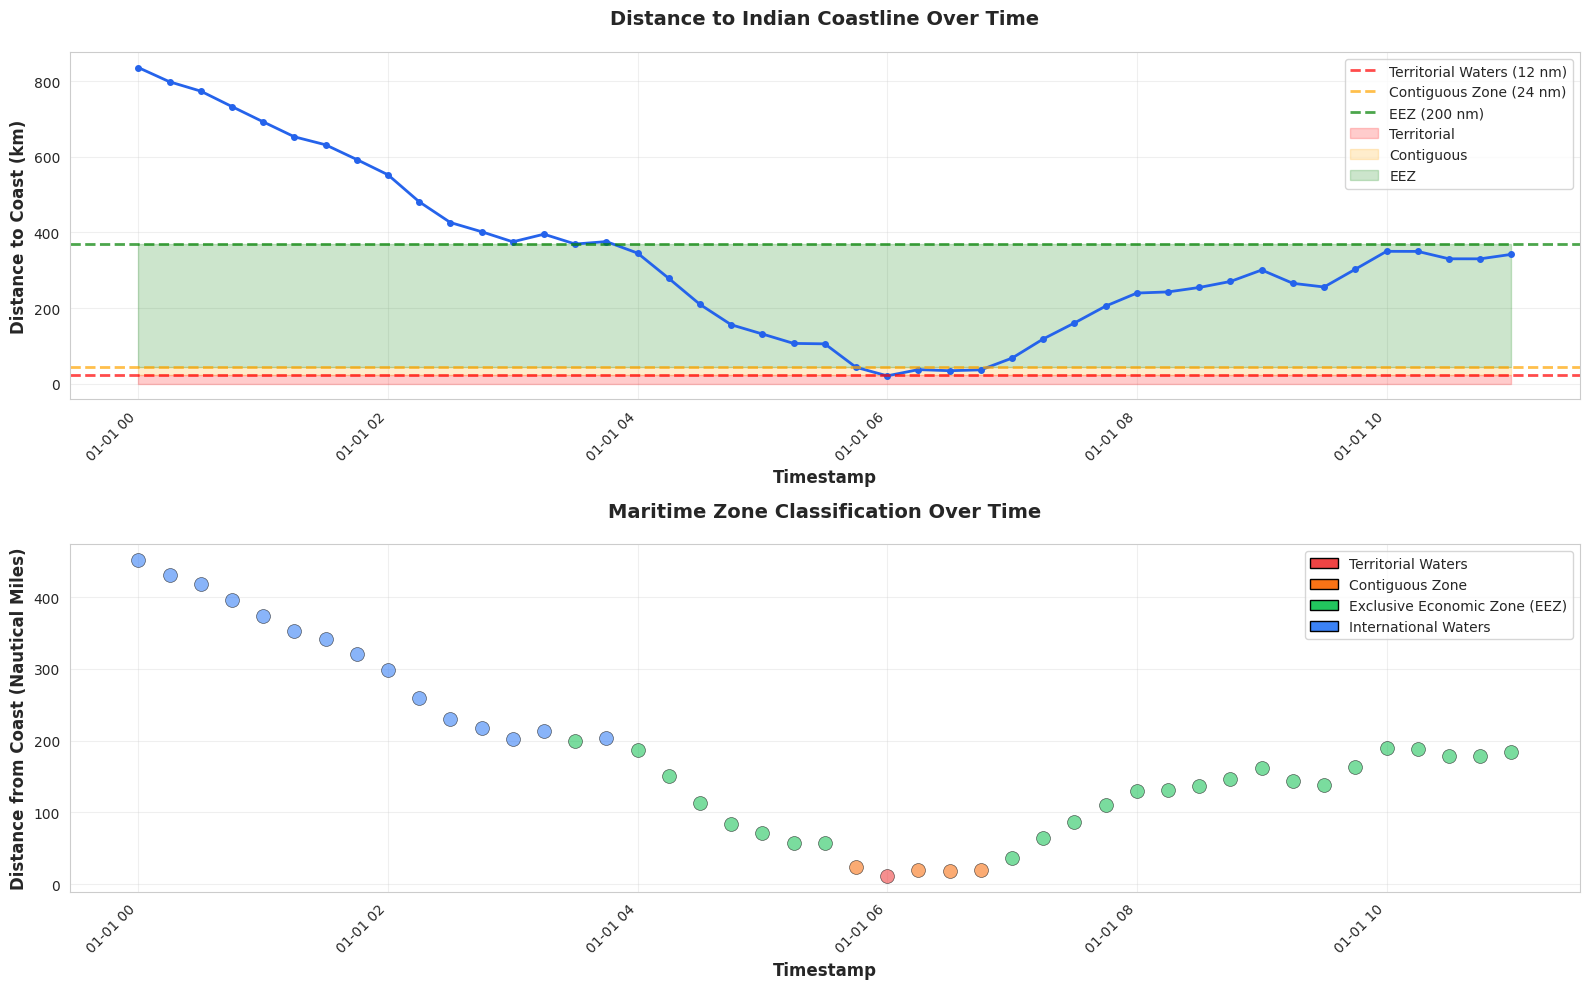

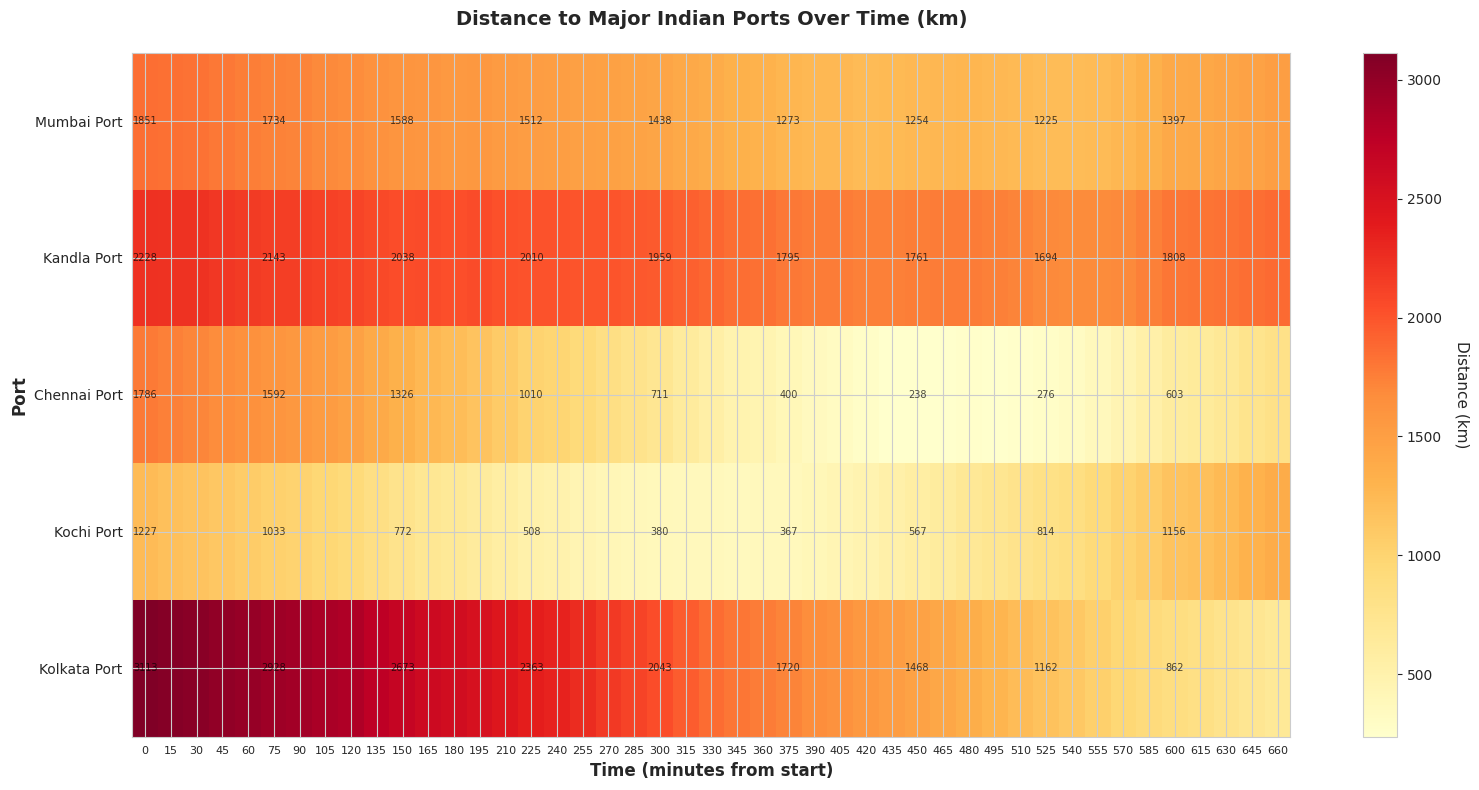

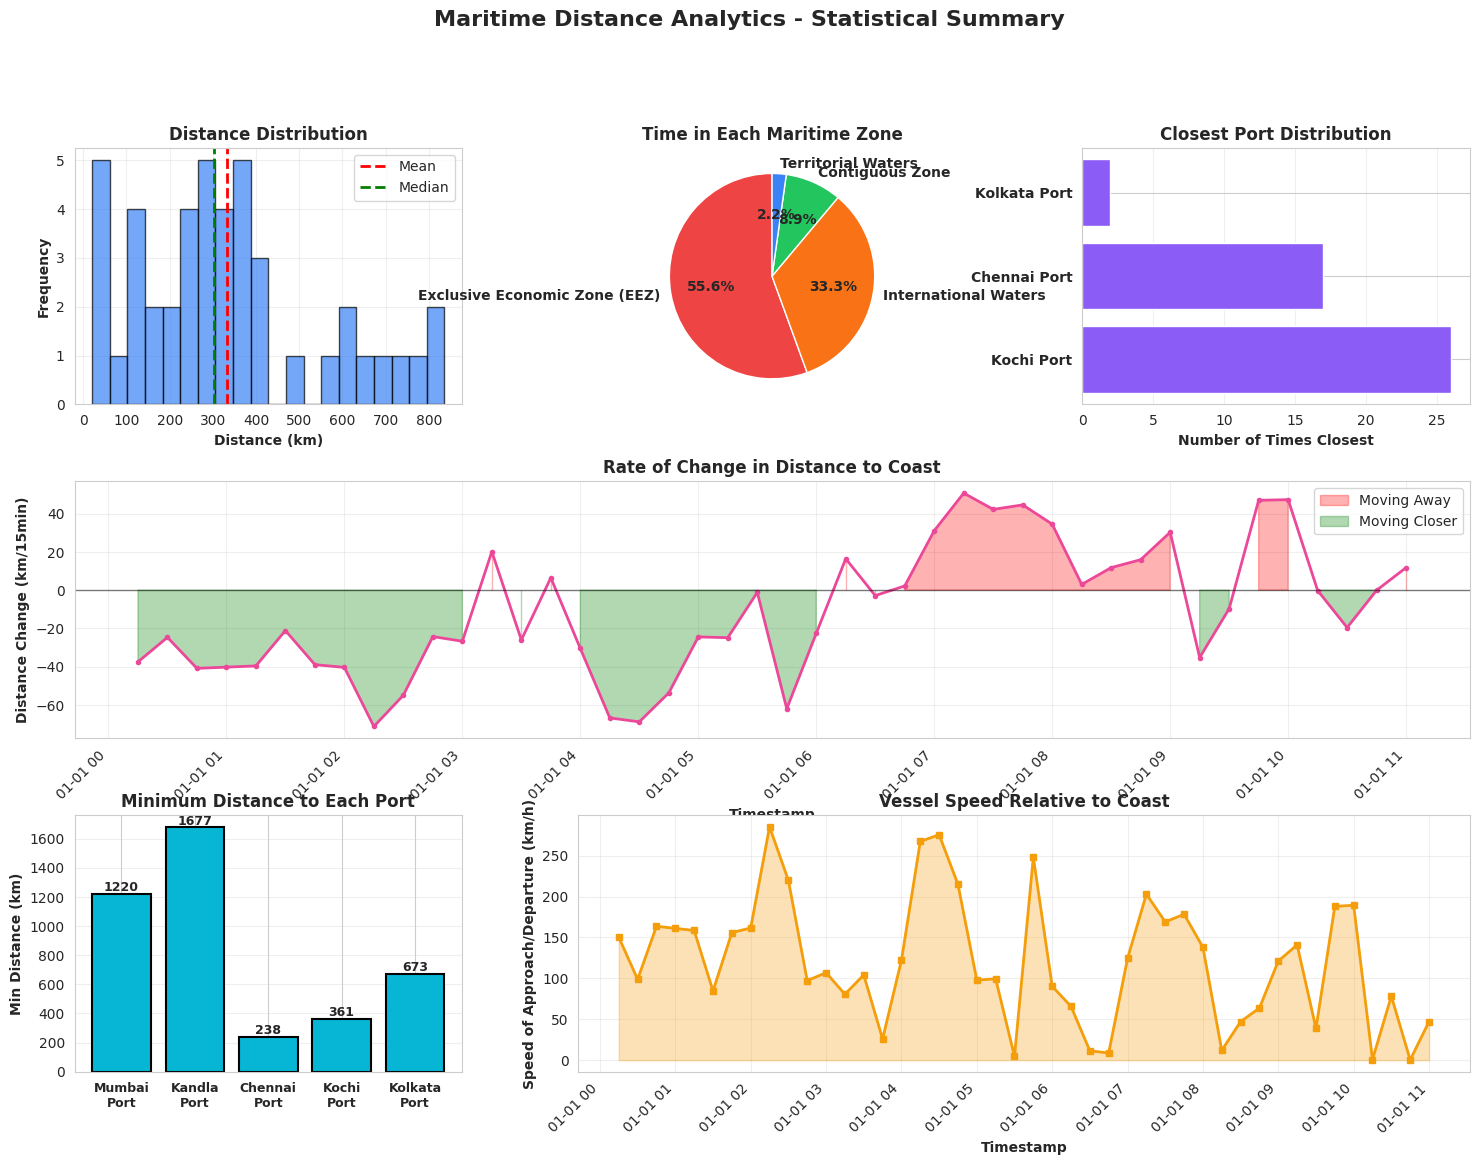

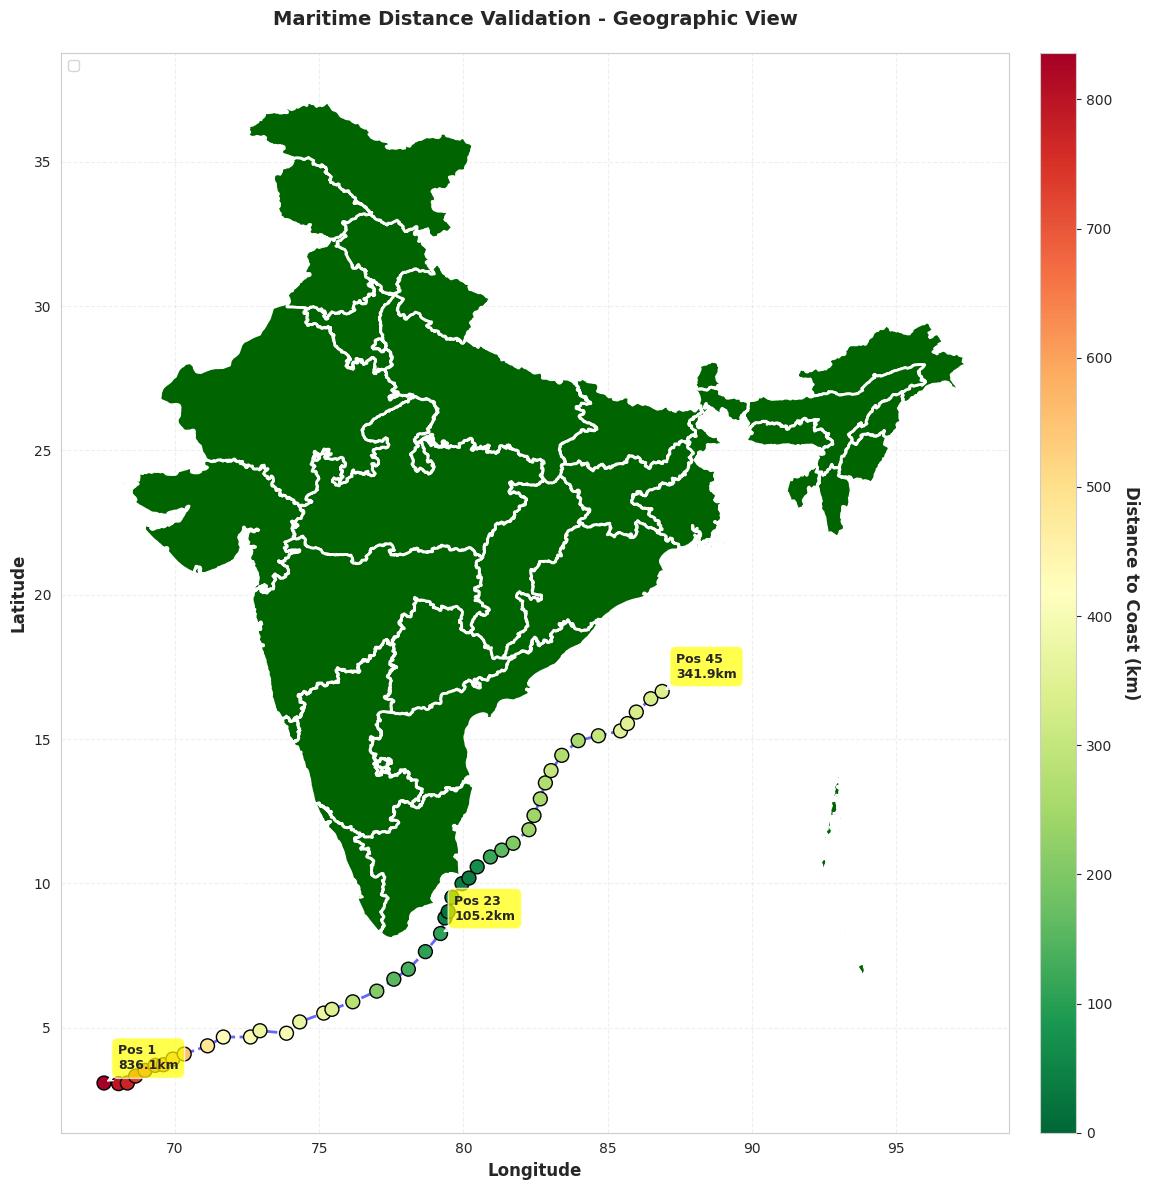

In [4]:
"""
Maritime Distance Visualization & Validation Suite
Comprehensive visualizations using Folium, GeoPandas, and Matplotlib
"""

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import folium
from folium import plugins
from shapely.geometry import Point, LineString
import json

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# ============================================================================
# 1. LOAD DATA
# ============================================================================

def load_results():
    """Load calculated distance results"""
    coast_dist = pd.read_csv('ais_coast_distances.csv')
    port_dist = pd.read_csv('ais_port_distances.csv')
    zone_info = pd.read_csv('ais_maritime_zones.csv')
    
    # Convert timestamps
    coast_dist['timestamp'] = pd.to_datetime(coast_dist['timestamp'])
    port_dist['timestamp'] = pd.to_datetime(port_dist['timestamp'])
    zone_info['timestamp'] = pd.to_datetime(zone_info['timestamp'])
    
    return coast_dist, port_dist, zone_info

def load_coastline(path):
    """Load coastline GeoJSON"""
    gdf = gpd.read_file(path)
    if gdf.crs is None:
        gdf.set_crs('EPSG:4326', inplace=True)
    return gdf

# ============================================================================
# 2. MATPLOTLIB VISUALIZATIONS
# ============================================================================

def plot_distance_over_time(coast_dist, zone_info):
    """
    Plot 1: Distance to coast over time with maritime zones
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
    
    # Plot 1: Distance to coast over time
    ax1.plot(coast_dist['timestamp'], coast_dist['distance_to_coast_km'], 
             linewidth=2, color='#2563eb', marker='o', markersize=4)
    
    # Add maritime zone boundaries
    ax1.axhline(y=12*1.852, color='red', linestyle='--', linewidth=2, 
                label='Territorial Waters (12 nm)', alpha=0.7)
    ax1.axhline(y=24*1.852, color='orange', linestyle='--', linewidth=2, 
                label='Contiguous Zone (24 nm)', alpha=0.7)
    ax1.axhline(y=200*1.852, color='green', linestyle='--', linewidth=2, 
                label='EEZ (200 nm)', alpha=0.7)
    
    ax1.fill_between(coast_dist['timestamp'], 0, 12*1.852, 
                     alpha=0.2, color='red', label='Territorial')
    ax1.fill_between(coast_dist['timestamp'], 12*1.852, 24*1.852, 
                     alpha=0.2, color='orange', label='Contiguous')
    ax1.fill_between(coast_dist['timestamp'], 24*1.852, 200*1.852, 
                     alpha=0.2, color='green', label='EEZ')
    
    ax1.set_xlabel('Timestamp', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Distance to Coast (km)', fontsize=12, fontweight='bold')
    ax1.set_title('Distance to Indian Coastline Over Time', 
                  fontsize=14, fontweight='bold', pad=20)
    ax1.legend(loc='upper right', fontsize=10)
    ax1.grid(True, alpha=0.3)
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Plot 2: Maritime zone timeline
    zone_colors = {
        'Territorial Waters': '#ef4444',
        'Contiguous Zone': '#f97316',
        'Exclusive Economic Zone (EEZ)': '#22c55e',
        'International Waters': '#3b82f6'
    }
    
    for i, row in zone_info.iterrows():
        color = zone_colors.get(row['maritime_zone'], '#gray')
        ax2.scatter(row['timestamp'], row['distance_nm'], 
                   c=color, s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
    
    ax2.set_xlabel('Timestamp', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Distance from Coast (Nautical Miles)', fontsize=12, fontweight='bold')
    ax2.set_title('Maritime Zone Classification Over Time', 
                  fontsize=14, fontweight='bold', pad=20)
    
    # Create custom legend
    legend_elements = [mpatches.Patch(facecolor=color, edgecolor='black', label=zone)
                      for zone, color in zone_colors.items()]
    ax2.legend(handles=legend_elements, loc='upper right', fontsize=10)
    ax2.grid(True, alpha=0.3)
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('distance_over_time.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: distance_over_time.png")
    return fig

def plot_port_distances_heatmap(port_dist):
    """
    Plot 2: Heatmap of distances to all ports over time
    """
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Select only distance columns
    port_cols = [col for col in port_dist.columns if col.startswith('dist_to_')]
    port_names = [col.replace('dist_to_', '').replace('_', ' ') 
                  for col in port_cols]
    
    # Create matrix for heatmap
    distance_matrix = port_dist[port_cols].T
    
    # Create heatmap
    im = ax.imshow(distance_matrix, aspect='auto', cmap='YlOrRd', 
                   interpolation='nearest')
    
    # Set ticks
    ax.set_xticks(np.arange(len(port_dist)))
    ax.set_yticks(np.arange(len(port_cols)))
    ax.set_xticklabels([f"{i*15}" for i in range(len(port_dist))], 
                       fontsize=8)
    ax.set_yticklabels(port_names, fontsize=10)
    
    # Labels
    ax.set_xlabel('Time (minutes from start)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Port', fontsize=12, fontweight='bold')
    ax.set_title('Distance to Major Indian Ports Over Time (km)', 
                 fontsize=14, fontweight='bold', pad=20)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Distance (km)', rotation=270, labelpad=20, fontsize=11)
    
    # Add text annotations for key values
    for i in range(len(port_cols)):
        for j in range(0, len(port_dist), 5):  # Every 5th point
            text = ax.text(j, i, f'{distance_matrix.iloc[i, j]:.0f}',
                          ha="center", va="center", color="black", 
                          fontsize=7, alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('port_distances_heatmap.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: port_distances_heatmap.png")
    return fig

def plot_statistical_summary(coast_dist, port_dist, zone_info):
    """
    Plot 3: Statistical summary dashboard
    """
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Distance distribution histogram
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.hist(coast_dist['distance_to_coast_km'], bins=20, 
             color='#3b82f6', alpha=0.7, edgecolor='black')
    ax1.axvline(coast_dist['distance_to_coast_km'].mean(), 
                color='red', linestyle='--', linewidth=2, label='Mean')
    ax1.axvline(coast_dist['distance_to_coast_km'].median(), 
                color='green', linestyle='--', linewidth=2, label='Median')
    ax1.set_xlabel('Distance (km)', fontweight='bold')
    ax1.set_ylabel('Frequency', fontweight='bold')
    ax1.set_title('Distance Distribution', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Zone distribution pie chart
    ax2 = fig.add_subplot(gs[0, 1])
    zone_counts = zone_info['maritime_zone'].value_counts()
    colors = ['#ef4444', '#f97316', '#22c55e', '#3b82f6']
    ax2.pie(zone_counts.values, labels=zone_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90, textprops={'fontweight': 'bold'})
    ax2.set_title('Time in Each Maritime Zone', fontweight='bold')
    
    # 3. Closest port over time
    ax3 = fig.add_subplot(gs[0, 2])
    port_cols = [col for col in port_dist.columns if col.startswith('dist_to_')]
    closest_ports = port_dist[port_cols].idxmin(axis=1)
    closest_ports = closest_ports.str.replace('dist_to_', '').str.replace('_', ' ')
    port_counts = closest_ports.value_counts()
    ax3.barh(range(len(port_counts)), port_counts.values, color='#8b5cf6')
    ax3.set_yticks(range(len(port_counts)))
    ax3.set_yticklabels(port_counts.index, fontweight='bold')
    ax3.set_xlabel('Number of Times Closest', fontweight='bold')
    ax3.set_title('Closest Port Distribution', fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='x')
    
    # 4. Distance rate of change
    ax4 = fig.add_subplot(gs[1, :])
    coast_dist['distance_change'] = coast_dist['distance_to_coast_km'].diff()
    ax4.plot(coast_dist['timestamp'], coast_dist['distance_change'], 
             linewidth=2, color='#ec4899', marker='o', markersize=3)
    ax4.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    ax4.fill_between(coast_dist['timestamp'], 0, coast_dist['distance_change'],
                     where=(coast_dist['distance_change'] > 0), 
                     alpha=0.3, color='red', label='Moving Away')
    ax4.fill_between(coast_dist['timestamp'], 0, coast_dist['distance_change'],
                     where=(coast_dist['distance_change'] <= 0), 
                     alpha=0.3, color='green', label='Moving Closer')
    ax4.set_xlabel('Timestamp', fontweight='bold')
    ax4.set_ylabel('Distance Change (km/15min)', fontweight='bold')
    ax4.set_title('Rate of Change in Distance to Coast', fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # 5. Min distance to each port
    ax5 = fig.add_subplot(gs[2, 0])
    min_distances = port_dist[port_cols].min()
    port_names = [col.replace('dist_to_', '').replace('_', '\n') 
                  for col in port_cols]
    bars = ax5.bar(range(len(min_distances)), min_distances.values, 
                   color='#06b6d4', edgecolor='black', linewidth=1.5)
    ax5.set_xticks(range(len(min_distances)))
    ax5.set_xticklabels(port_names, fontsize=9, fontweight='bold')
    ax5.set_ylabel('Min Distance (km)', fontweight='bold')
    ax5.set_title('Minimum Distance to Each Port', fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}', ha='center', va='bottom', 
                fontweight='bold', fontsize=9)
    
    # 6. Speed of approach to coast
    ax6 = fig.add_subplot(gs[2, 1:])
    coast_dist['speed_kmh'] = abs(coast_dist['distance_change']) / 0.25  # 15min = 0.25hr
    ax6.plot(coast_dist['timestamp'], coast_dist['speed_kmh'], 
             linewidth=2, color='#f59e0b', marker='s', markersize=4)
    ax6.fill_between(coast_dist['timestamp'], 0, coast_dist['speed_kmh'],
                     alpha=0.3, color='#f59e0b')
    ax6.set_xlabel('Timestamp', fontweight='bold')
    ax6.set_ylabel('Speed of Approach/Departure (km/h)', fontweight='bold')
    ax6.set_title('Vessel Speed Relative to Coast', fontweight='bold')
    ax6.grid(True, alpha=0.3)
    plt.setp(ax6.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.suptitle('Maritime Distance Analytics - Statistical Summary', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    plt.savefig('statistical_summary.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: statistical_summary.png")
    return fig

# ============================================================================
# 3. ADVANCED FOLIUM VISUALIZATIONS
# ============================================================================

def create_interactive_validation_map(coast_dist, zone_info, coastline_gdf):
    """
    Create comprehensive interactive Folium map with all validation layers
    """
    # Calculate center
    center_lat = coast_dist['latitude'].mean()
    center_lon = coast_dist['longitude'].mean()
    
    # Create map with multiple tile layers
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=5,
        tiles='OpenStreetMap'
    )
    
    # Add alternative tile layers
    folium.TileLayer('CartoDB positron', name='Light Map').add_to(m)
    folium.TileLayer('CartoDB dark_matter', name='Dark Map').add_to(m)
    folium.TileLayer('OpenTopoMap', name='Terrain').add_to(m)
    
    # 1. Add coastline
    coastline_layer = folium.FeatureGroup(name='India Coastline', show=True)
    folium.GeoJson(
        coastline_gdf,
        style_function=lambda x: {
            'color': '#059669',
            'weight': 3,
            'fillOpacity': 0
        },
        tooltip='India Coastline'
    ).add_to(coastline_layer)
    coastline_layer.add_to(m)
    
    # 2. Add maritime zone boundaries (circles around each AIS point)
    zones_layer = folium.FeatureGroup(name='Maritime Zones', show=False)
    
    zone_colors = {
        'Territorial Waters': '#ef4444',
        'Contiguous Zone': '#f97316',
        'Exclusive Economic Zone (EEZ)': '#22c55e',
        'International Waters': '#3b82f6'
    }
    
    for idx, row in zone_info.iterrows():
        color = zone_colors.get(row['maritime_zone'], '#gray')
        
        # Add circle showing distance
        folium.Circle(
            location=[coast_dist.iloc[idx]['latitude'], coast_dist.iloc[idx]['longitude']],
            radius=row['distance_km'] * 1000,  # Convert to meters
            color=color,
            fill=True,
            fillColor=color,
            fillOpacity=0.1,
            weight=1,
            popup=f"Zone: {row['maritime_zone']}<br>Distance: {row['distance_km']:.2f} km"
        ).add_to(zones_layer)
    
    zones_layer.add_to(m)
    
    # 3. Add AIS track with graduated colors based on distance
    track_layer = folium.FeatureGroup(name='AIS Track (Color by Distance)', show=True)
    
    distances = coast_dist['distance_to_coast_km'].values
    min_dist, max_dist = distances.min(), distances.max()
    
    # Create route line segments with colors
    for i in range(len(coast_dist) - 1):
        start = [coast_dist.iloc[i]['latitude'], coast_dist.iloc[i]['longitude']]
        end = [coast_dist.iloc[i+1]['latitude'], coast_dist.iloc[i+1]['longitude']]
        
        # Normalize distance for color
        dist = coast_dist.iloc[i]['distance_to_coast_km']
        normalized = (dist - min_dist) / (max_dist - min_dist)
        
        # Color gradient: green (close) -> yellow -> red (far)
        if normalized < 0.33:
            color = '#22c55e'
        elif normalized < 0.66:
            color = '#f59e0b'
        else:
            color = '#ef4444'
        
        folium.PolyLine(
            locations=[start, end],
            color=color,
            weight=4,
            opacity=0.8
        ).add_to(track_layer)
    
    track_layer.add_to(m)
    
    # 4. Add AIS positions with detailed popups
    positions_layer = folium.FeatureGroup(name='AIS Positions', show=True)
    
    for idx, row in coast_dist.iterrows():
        # Determine marker color based on distance
        dist = row['distance_to_coast_km']
        if dist < 50:
            marker_color = 'green'
            icon = 'ship'
        elif dist < 150:
            marker_color = 'orange'
            icon = 'ship'
        else:
            marker_color = 'red'
            icon = 'ship'
        
        # Create detailed popup
        popup_html = f"""
        <div style="font-family: Arial; width: 250px;">
            <h4 style="margin: 0; color: #1f2937;">AIS Position #{idx + 1}</h4>
            <hr style="margin: 5px 0;">
            <b>Timestamp:</b> {row['timestamp']}<br>
            <b>Coordinates:</b><br>
            &nbsp;&nbsp;Lat: {row['latitude']:.4f}°<br>
            &nbsp;&nbsp;Lon: {row['longitude']:.4f}°<br>
            <b>Distance to Coast:</b> {row['distance_to_coast_km']:.2f} km<br>
            <b>Zone:</b> {zone_info.iloc[idx]['maritime_zone']}<br>
            <b>Distance (nm):</b> {zone_info.iloc[idx]['distance_nm']:.2f} nm
        </div>
        """
        
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=folium.Popup(popup_html, max_width=300),
            tooltip=f"Position {idx + 1}: {row['distance_to_coast_km']:.1f} km",
            icon=folium.Icon(color=marker_color, icon=icon, prefix='fa')
        ).add_to(positions_layer)
    
    positions_layer.add_to(m)
    
    # 5. Add lines connecting AIS positions to nearest coast point
    connections_layer = folium.FeatureGroup(name='Distance Lines to Coast', show=False)
    
    for idx, row in coast_dist.iterrows():
        # Parse nearest coast point (it's stored as string)
        nearest_str = row['nearest_coast_point']
        # Extract coordinates from POINT string
        coords_str = nearest_str.replace('POINT (', '').replace(')', '')
        lon, lat = map(float, coords_str.split())
        
        # Draw line from AIS position to nearest coast point
        folium.PolyLine(
            locations=[
                [row['latitude'], row['longitude']],
                [lat, lon]
            ],
            color='#6366f1',
            weight=2,
            opacity=0.6,
            dash_array='5, 5',
            popup=f"Distance: {row['distance_to_coast_km']:.2f} km"
        ).add_to(connections_layer)
        
        # Mark the nearest coast point
        folium.CircleMarker(
            location=[lat, lon],
            radius=3,
            color='#dc2626',
            fill=True,
            fillColor='#dc2626',
            fillOpacity=0.8,
            popup=f"Nearest coast point to position {idx + 1}"
        ).add_to(connections_layer)
    
    connections_layer.add_to(m)
    
    # 6. Add port locations
    ports_layer = folium.FeatureGroup(name='Major Ports', show=True)
    
    port_locations = {
        'Mumbai Port': [18.92, 72.84],
        'Kandla Port': [23.00, 70.22],
        'Chennai Port': [13.08, 80.30],
        'Kochi Port': [9.96, 76.27],
        'Kolkata Port': [22.58, 88.33]
    }
    
    for port_name, coords in port_locations.items():
        folium.Marker(
            location=coords,
            popup=f"<b>{port_name}</b>",
            tooltip=port_name,
            icon=folium.Icon(color='blue', icon='anchor', prefix='fa')
        ).add_to(ports_layer)
        
        # Add port radius circle (50km)
        folium.Circle(
            location=coords,
            radius=50000,
            color='#3b82f6',
            fill=True,
            fillColor='#3b82f6',
            fillOpacity=0.1,
            weight=2,
            dash_array='10, 5',
            popup=f"{port_name} - 50km radius"
        ).add_to(ports_layer)
    
    ports_layer.add_to(m)
    
    # 7. Add heatmap of positions (density)
    heat_data = [[row['latitude'], row['longitude']] 
                 for _, row in coast_dist.iterrows()]
    
    heatmap_layer = plugins.HeatMap(
        heat_data,
        name='Position Density Heatmap',
        min_opacity=0.2,
        max_opacity=0.8,
        radius=25,
        blur=15,
        gradient={0.4: 'blue', 0.65: 'lime', 0.8: 'yellow', 1.0: 'red'},
        show=False
    )
    m.add_child(heatmap_layer)
    
    # 8. Add mini map
    minimap = plugins.MiniMap(toggle_display=True)
    m.add_child(minimap)
    
    # 9. Add measure control
    m.add_child(folium.plugins.MeasureControl())
    
    # 10. Add mouse position
    m.add_child(folium.plugins.MousePosition())
    
    # 11. Add fullscreen option
    plugins.Fullscreen().add_to(m)
    
    # 12. Add legend
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; right: 50px; width: 280px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:12px; padding: 15px; border-radius: 5px;
                box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
        <h4 style="margin-top:0; color: #1f2937;">Maritime Distance Legend</h4>
        <p style="margin: 5px 0;">
            <span style="color: #22c55e; font-size: 18px;">━━</span> 
            <b>Close to Coast</b> (&lt;50 km)
        </p>
        <p style="margin: 5px 0;">
            <span style="color: #f59e0b; font-size: 18px;">━━</span> 
            <b>Moderate Distance</b> (50-150 km)
        </p>
        <p style="margin: 5px 0;">
            <span style="color: #ef4444; font-size: 18px;">━━</span> 
            <b>Far from Coast</b> (&gt;150 km)
        </p>
        <hr>
        <p style="margin: 5px 0; font-size: 11px;">
            <span style="color: #ef4444;">●</span> Territorial (12 nm)<br>
            <span style="color: #f97316;">●</span> Contiguous (24 nm)<br>
            <span style="color: #22c55e;">●</span> EEZ (200 nm)<br>
            <span style="color: #3b82f6;">●</span> International
        </p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Add title
    title_html = '''
    <div style="position: fixed; 
                top: 10px; left: 50px; width: 500px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:16px; font-weight: bold; padding: 10px;
                border-radius: 5px; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
        <span style="color: #1f2937;">🚢 Maritime Distance Validation Map</span>
        <br>
        <span style="font-size: 12px; font-weight: normal; color: #6b7280;">
            Interactive visualization of AIS track with distance calculations
        </span>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(title_html))
    
    # Add layer control
    folium.LayerControl(collapsed=False).add_to(m)
    
    return m

# ============================================================================
# 4. GEOPANDAS STATIC MAP VISUALIZATION
# ============================================================================

def create_geopandas_validation_map(coast_dist, coastline_gdf):
    """
    Create static map using GeoPandas and Matplotlib
    """
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Plot coastline
    coastline_gdf.plot(ax=ax, color='darkgreen', linewidth=2, 
                       label='India Coastline', zorder=1)
    
    # Create GeoDataFrame from AIS points
    geometry = [Point(xy) for xy in zip(coast_dist['longitude'], 
                                        coast_dist['latitude'])]
    ais_gdf = gpd.GeoDataFrame(coast_dist, geometry=geometry, crs='EPSG:4326')
    
    # Plot AIS track with color gradient
    distances = coast_dist['distance_to_coast_km'].values
    
    # Plot points
    scatter = ax.scatter(ais_gdf.geometry.x, ais_gdf.geometry.y,
                        c=distances, cmap='RdYlGn_r', s=100, 
                        edgecolors='black', linewidth=1, zorder=3,
                        vmin=0, vmax=distances.max())
    
    # Plot route line
    route_line = LineString([(lon, lat) for lon, lat in 
                            zip(coast_dist['longitude'], coast_dist['latitude'])])
    gpd.GeoSeries([route_line]).plot(ax=ax, color='blue', linewidth=2, 
                                     alpha=0.6, linestyle='--', zorder=2)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', 
                       pad=0.02, aspect=30)
    cbar.set_label('Distance to Coast (km)', rotation=270, labelpad=20, 
                  fontsize=12, fontweight='bold')
    
    # Add point labels for first, middle, and last positions
    for idx in [0, len(coast_dist)//2, len(coast_dist)-1]:
        row = coast_dist.iloc[idx]
        ax.annotate(f'Pos {idx+1}\n{row["distance_to_coast_km"]:.1f}km',
                   xy=(row['longitude'], row['latitude']),
                   xytext=(10, 10), textcoords='offset points',
                   bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'),
                   fontsize=9, fontweight='bold')
    
    # Set labels and title
    ax.set_xlabel('Longitude', fontsize=12, fontweight='bold')
    ax.set_ylabel('Latitude', fontsize=12, fontweight='bold')
    ax.set_title('Maritime Distance Validation - Geographic View', 
                fontsize=14, fontweight='bold', pad=20)
    
    # Add grid
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='upper left', fontsize=10)
    
    # Set aspect ratio
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.savefig('geopandas_validation_map.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: geopandas_validation_map.png")
    return fig

# ============================================================================
# 5. MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("="*60)
    print("MARITIME DISTANCE VISUALIZATION & VALIDATION")
    print("="*60)
    
    # Load data
    print("\n1. Loading calculated results...")
    coast_dist, port_dist, zone_info = load_results()
    print(f"   ✓ Loaded {len(coast_dist)} AIS positions")
    print(f"   ✓ Loaded {len(port_dist)} port distance records")
    print(f"   ✓ Loaded {len(zone_info)} zone classifications")
    
    # Load coastline
    print("\n2. Loading coastline data...")
    coastline_path = '/home/crimsondeepdarshak/Desktop/Deep_Darshak/References/Build_1_docs/Straits_polygon/Coastline/India_coastal_line.json'
    coastline_gdf = load_coastline(coastline_path)
    print(f"   ✓ Loaded coastline with {len(coastline_gdf)} features")
    
    # Create matplotlib visualizations
    print("\n3. Creating Matplotlib visualizations...")
    print("   → Generating distance over time plot...")
    fig1 = plot_distance_over_time(coast_dist, zone_info)
    
    print("   → Generating port distances heatmap...")
    fig2 = plot_port_distances_heatmap(port_dist)
    
    print("   → Generating statistical summary dashboard...")
    fig3 = plot_statistical_summary(coast_dist, port_dist, zone_info)
    
    # Create Folium interactive map
    print("\n4. Creating interactive Folium validation map...")
    folium_map = create_interactive_validation_map(coast_dist, zone_info, coastline_gdf)
    folium_map.save('interactive_validation_map.html')
    print("   ✓ Saved: interactive_validation_map.html")
    
    # Create GeoPandas static map
    print("\n5. Creating GeoPandas static map...")
    fig4 = create_geopandas_validation_map(coast_dist, coastline_gdf)
    
    # Print summary statistics
    print("\n" + "="*60)
    print("VALIDATION SUMMARY")
    print("="*60)
    print(f"\n📊 Distance Statistics:")
    print(f"   • Minimum distance to coast: {coast_dist['distance_to_coast_km'].min():.2f} km")
    print(f"   • Maximum distance to coast: {coast_dist['distance_to_coast_km'].max():.2f} km")
    print(f"   • Mean distance to coast: {coast_dist['distance_to_coast_km'].mean():.2f} km")
    print(f"   • Median distance to coast: {coast_dist['distance_to_coast_km'].median():.2f} km")
    print(f"   • Std deviation: {coast_dist['distance_to_coast_km'].std():.2f} km")
    
    print(f"\n🌊 Maritime Zone Distribution:")
    for zone, count in zone_info['maritime_zone'].value_counts().items():
        percentage = (count / len(zone_info)) * 100
        print(f"   • {zone}: {count} positions ({percentage:.1f}%)")
    
    print(f"\n⚓ Port Proximity:")
    port_cols = [col for col in port_dist.columns if col.startswith('dist_to_')]
    for col in port_cols:
        port_name = col.replace('dist_to_', '').replace('_', ' ')
        min_dist = port_dist[col].min()
        print(f"   • Closest to {port_name}: {min_dist:.2f} km")
    
    print(f"\n📈 Vessel Movement:")
    coast_dist['distance_change'] = coast_dist['distance_to_coast_km'].diff()
    approaching = (coast_dist['distance_change'] < 0).sum()
    departing = (coast_dist['distance_change'] > 0).sum()
    print(f"   • Approaching coast: {approaching} intervals")
    print(f"   • Departing from coast: {departing} intervals")
    
    print("\n" + "="*60)
    print("GENERATED FILES:")
    print("="*60)
    print("   1. distance_over_time.png - Time series analysis")
    print("   2. port_distances_heatmap.png - Port proximity heatmap")
    print("   3. statistical_summary.png - Statistical dashboard")
    print("   4. interactive_validation_map.html - Interactive Folium map")
    print("   5. geopandas_validation_map.png - Static geographic map")
    print("\n✅ All visualizations created successfully!")
    print("="*60)

Loading AIS distance data...
Loaded 45 data points

DISTANCE vs TIMESTAMP VISUALIZATION SUITE

Generating 8 different visualization styles...

✓ Saved: plot1_basic_line.png


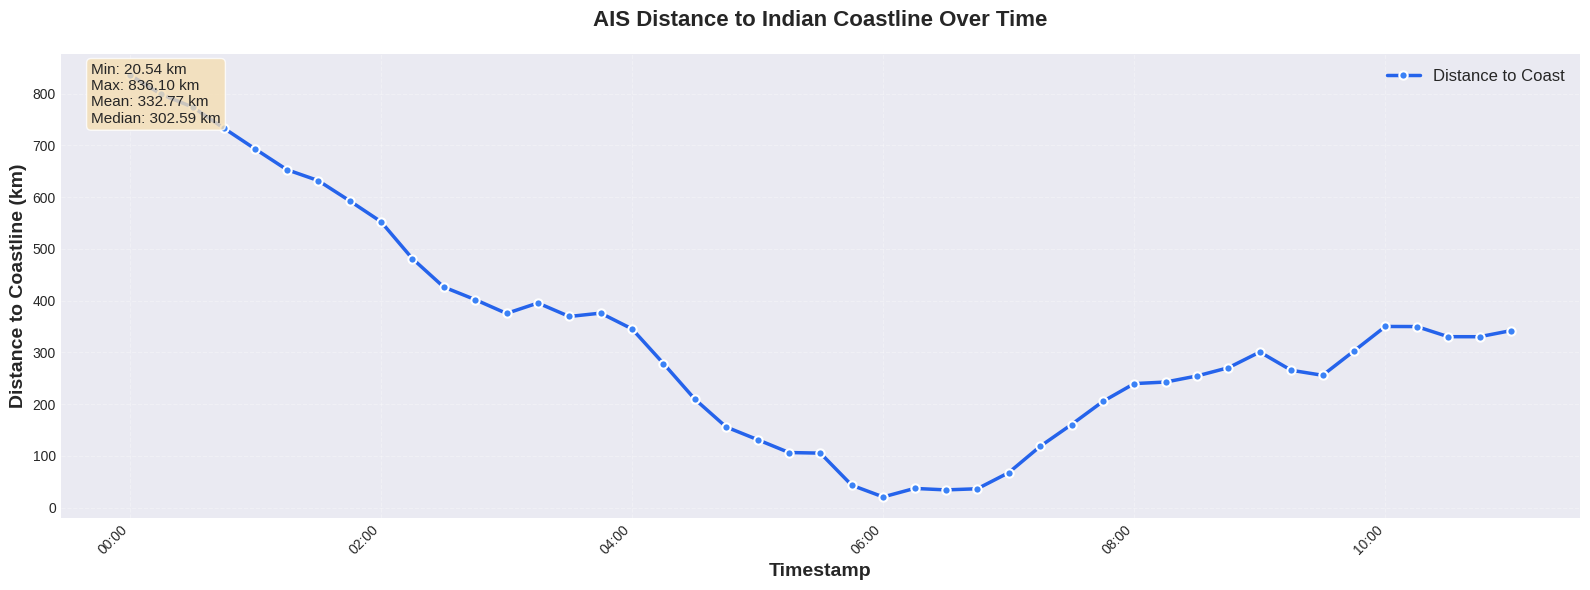

✓ Saved: plot2_maritime_zones.png


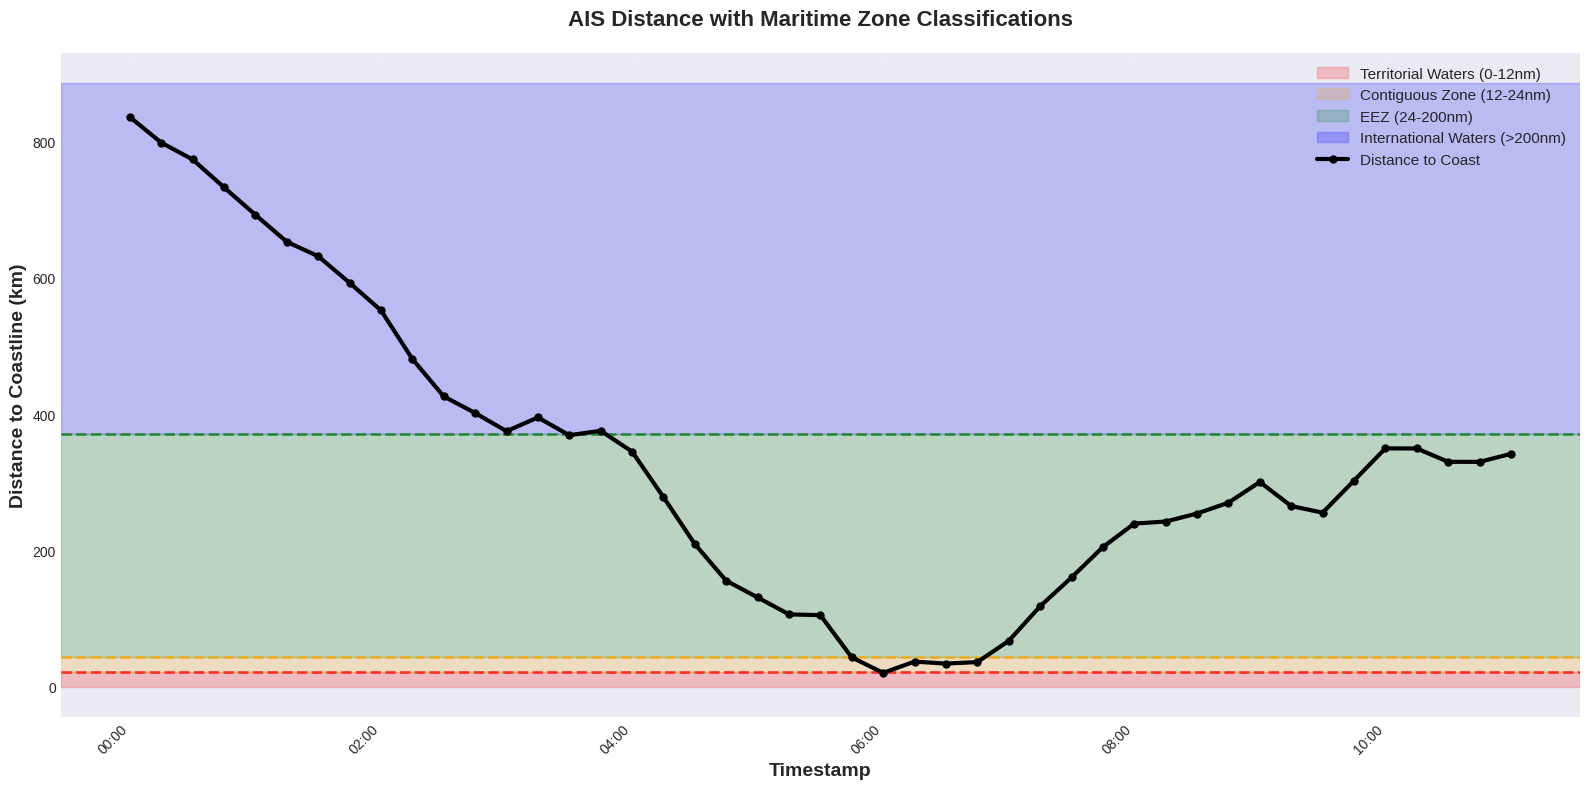

✓ Saved: plot3_area_gradient.png


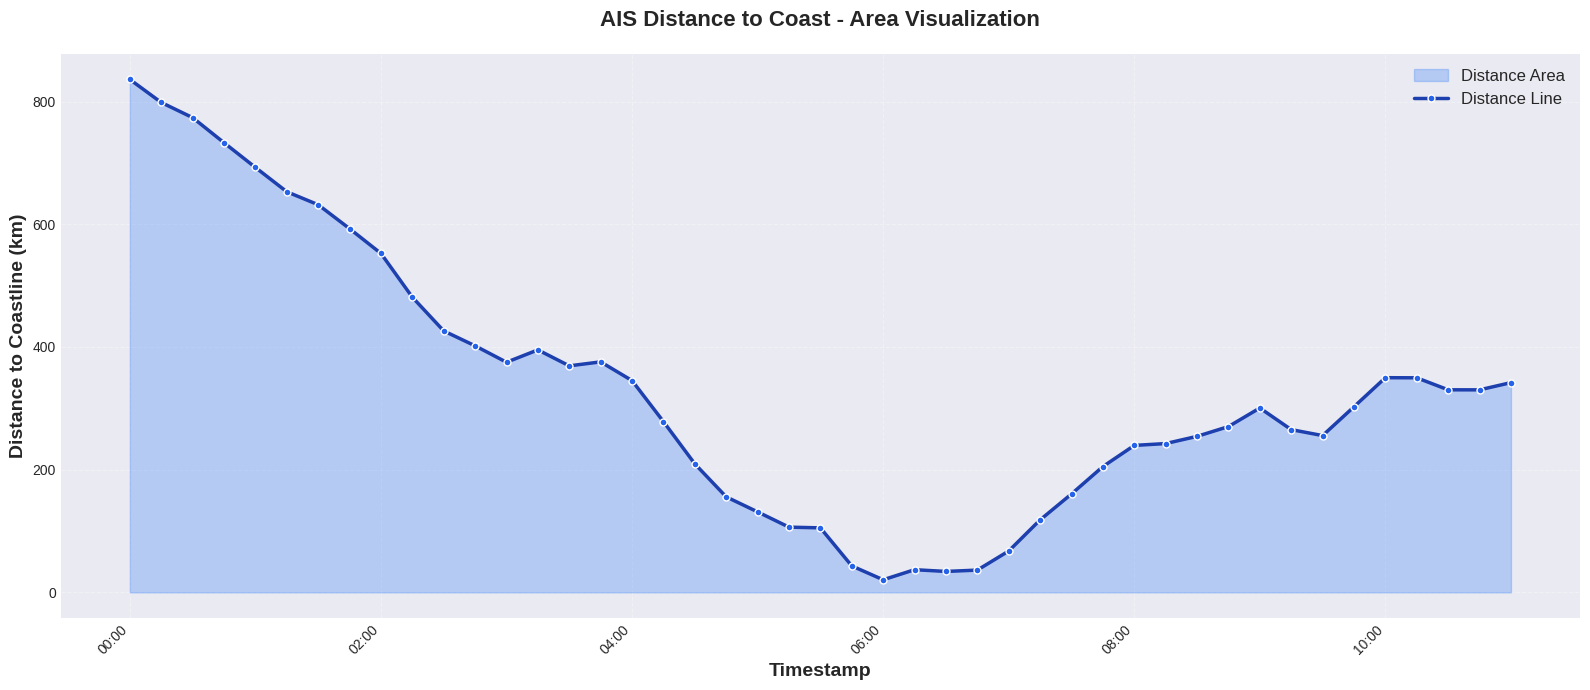

✓ Saved: plot4_color_coded.png


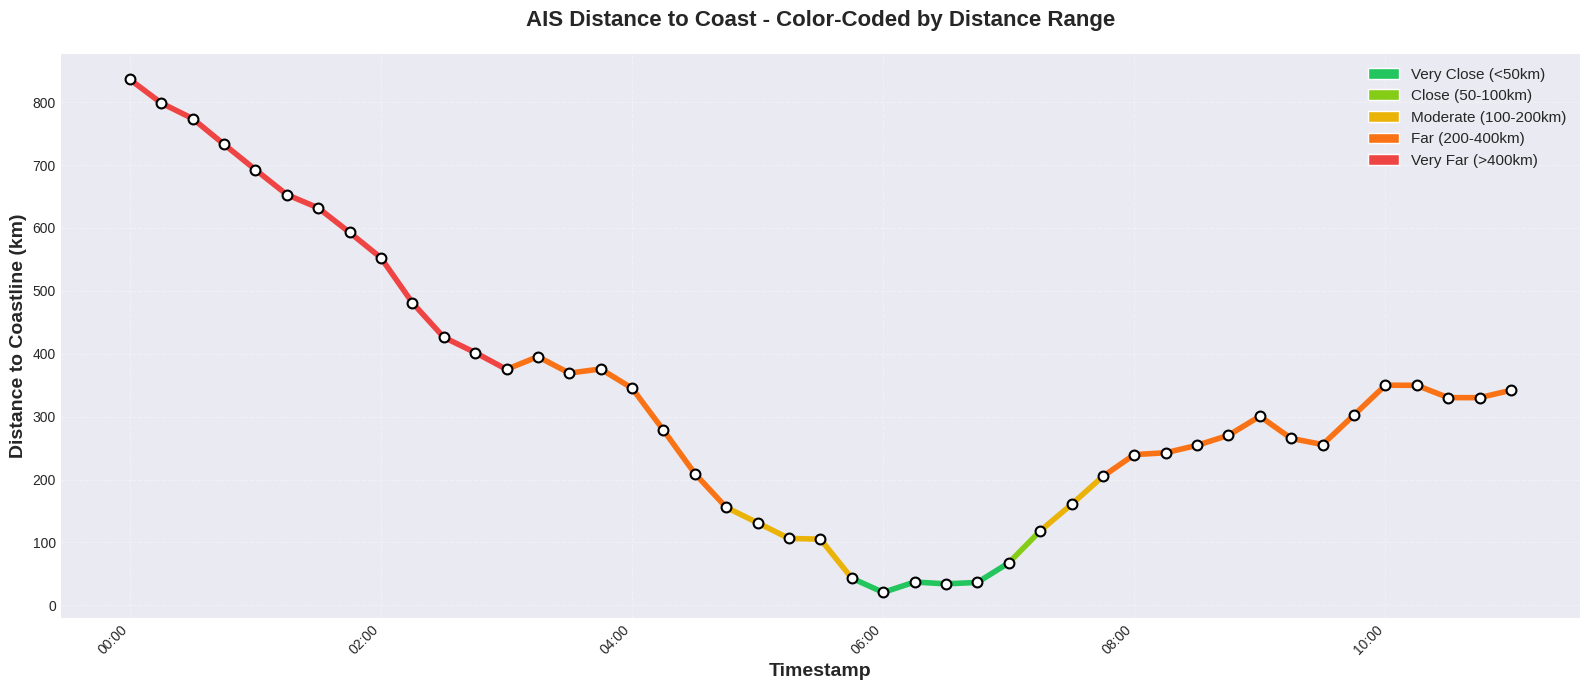

✓ Saved: plot5_dual_axis.png


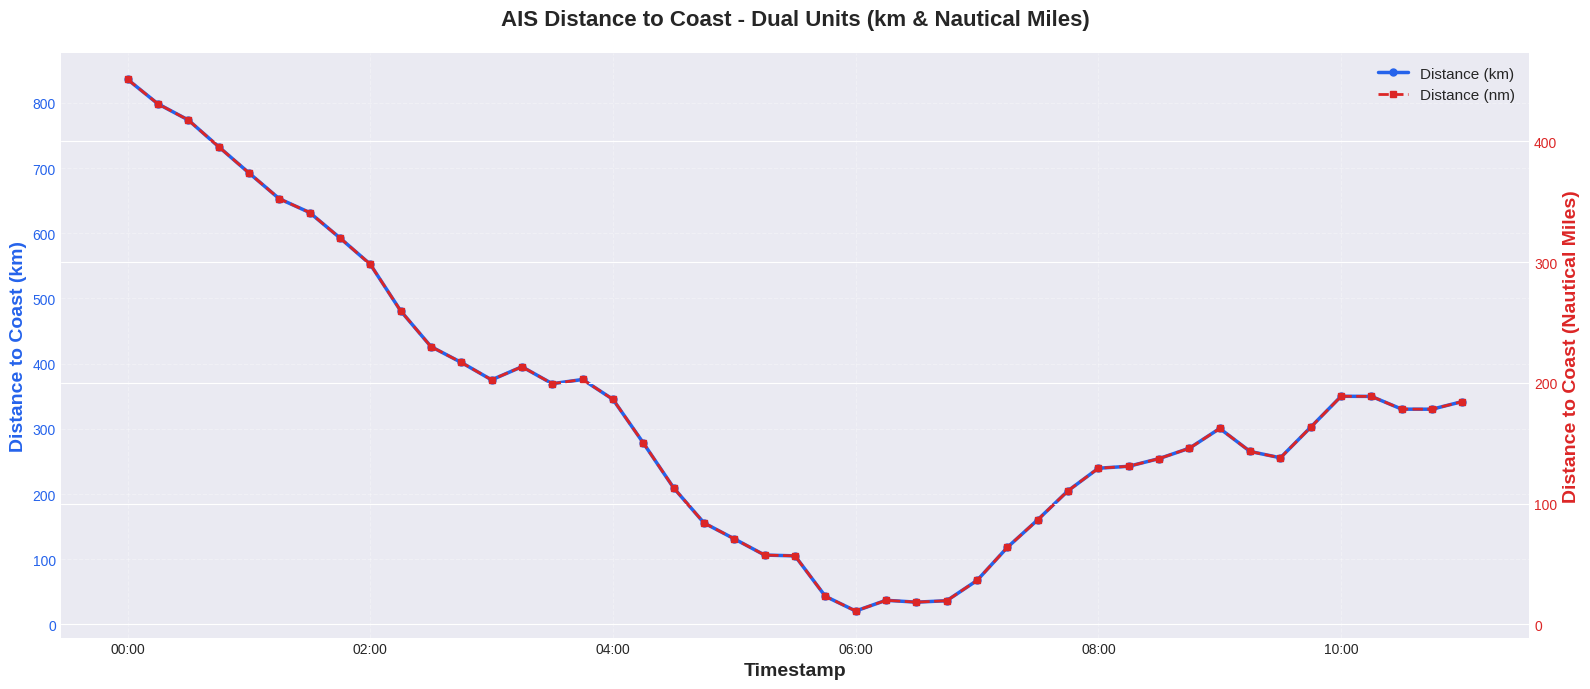

✓ Saved: plot6_step_plot.png


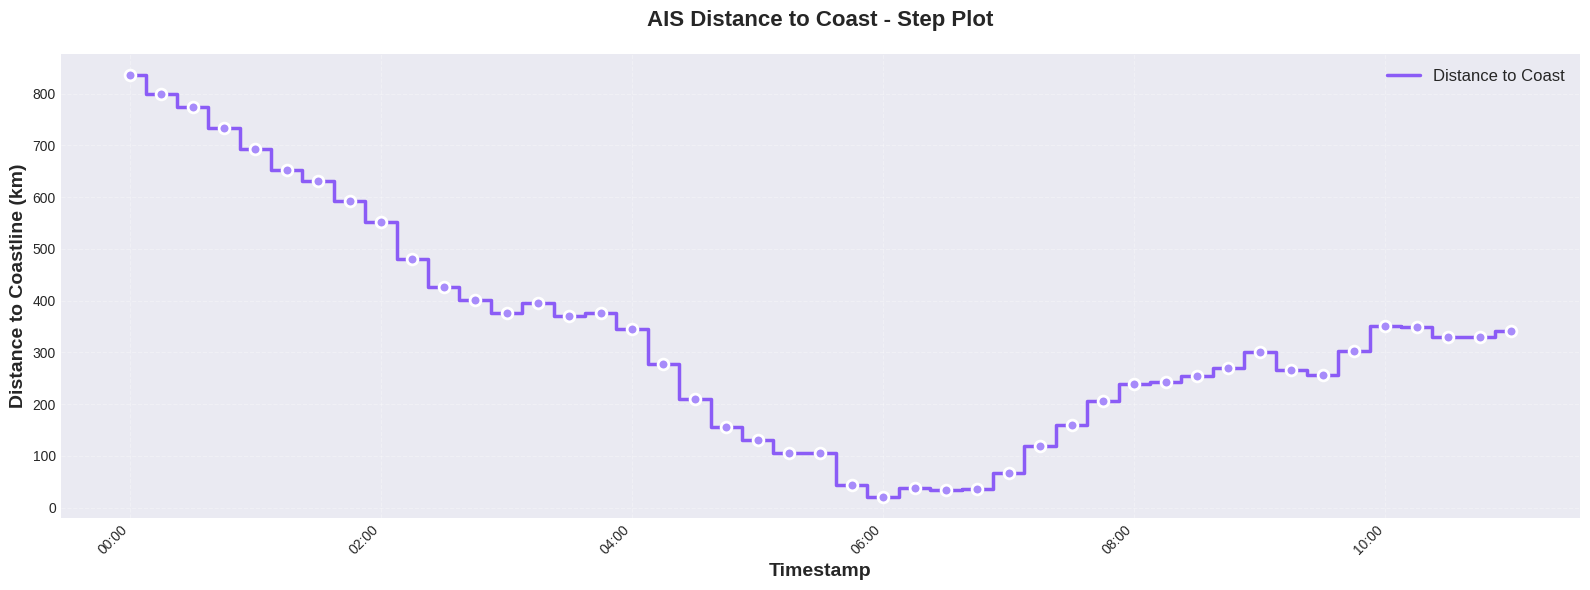

✓ Saved: plot7_bar_chart.png


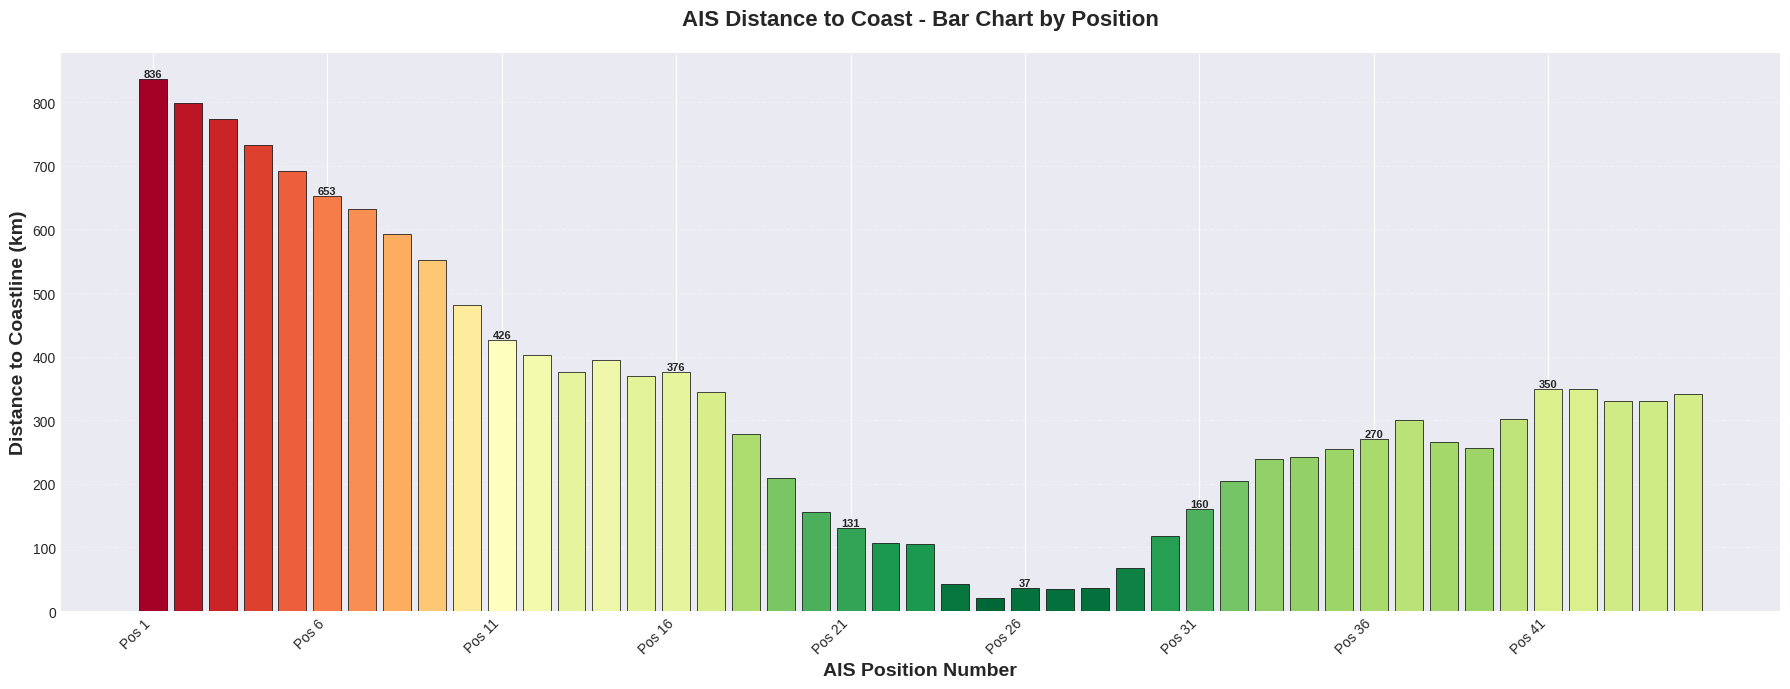

✓ Saved: plot8_dashboard.png


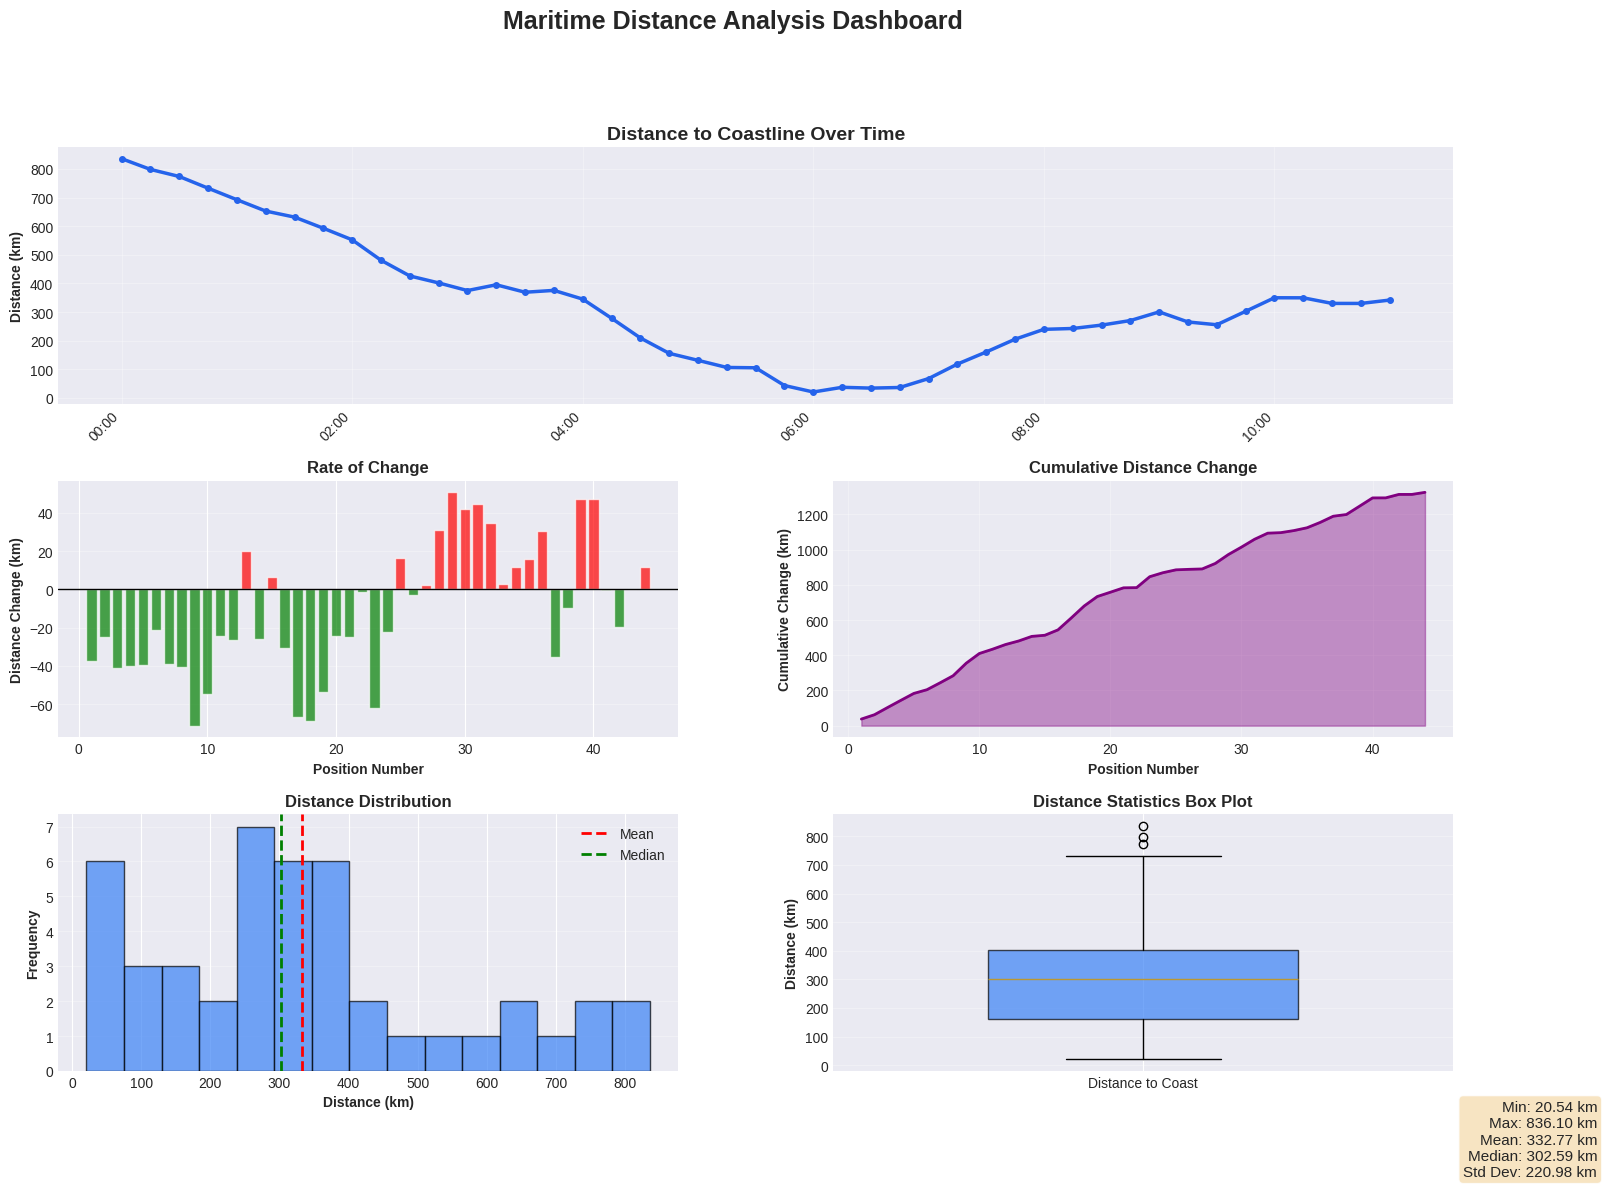


✅ ALL PLOTS GENERATED SUCCESSFULLY!

Generated Files:
  1. plot1_basic_line.png - Simple line plot with markers
  2. plot2_maritime_zones.png - With maritime zone boundaries
  3. plot3_area_gradient.png - Area plot with gradient fill
  4. plot4_color_coded.png - Color-coded by distance ranges
  5. plot5_dual_axis.png - Dual units (km & nautical miles)
  6. plot6_step_plot.png - Step plot showing discrete changes
  7. plot7_bar_chart.png - Bar chart by position
  8. plot8_dashboard.png - Comprehensive multi-panel dashboard


In [5]:
"""
Distance to Coastline vs Timestamp - Comprehensive Visualization
Multiple plot styles to analyze AIS distance data over time
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import seaborn as sns
from datetime import datetime

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load data
print("Loading AIS distance data...")
coast_dist = pd.read_csv('ais_coast_distances.csv')
zone_info = pd.read_csv('ais_maritime_zones.csv')

# Convert timestamps
coast_dist['timestamp'] = pd.to_datetime(coast_dist['timestamp'])
zone_info['timestamp'] = pd.to_datetime(zone_info['timestamp'])

print(f"Loaded {len(coast_dist)} data points")

# ============================================================================
# PLOT 1: Basic Line Plot with Markers
# ============================================================================

def plot_basic_line():
    """Simple line plot with markers"""
    fig, ax = plt.subplots(figsize=(16, 6))
    
    ax.plot(coast_dist['timestamp'], 
            coast_dist['distance_to_coast_km'],
            linewidth=2.5,
            color='#2563eb',
            marker='o',
            markersize=6,
            markerfacecolor='#3b82f6',
            markeredgecolor='white',
            markeredgewidth=1.5,
            label='Distance to Coast')
    
    ax.set_xlabel('Timestamp', fontsize=14, fontweight='bold')
    ax.set_ylabel('Distance to Coastline (km)', fontsize=14, fontweight='bold')
    ax.set_title('AIS Distance to Indian Coastline Over Time', 
                 fontsize=16, fontweight='bold', pad=20)
    
    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xticks(rotation=45, ha='right')
    
    # Add grid
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
    ax.legend(fontsize=12, loc='best')
    
    # Add statistics text box
    stats_text = f'Min: {coast_dist["distance_to_coast_km"].min():.2f} km\n'
    stats_text += f'Max: {coast_dist["distance_to_coast_km"].max():.2f} km\n'
    stats_text += f'Mean: {coast_dist["distance_to_coast_km"].mean():.2f} km\n'
    stats_text += f'Median: {coast_dist["distance_to_coast_km"].median():.2f} km'
    
    ax.text(0.02, 0.98, stats_text,
            transform=ax.transAxes,
            fontsize=11,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('plot1_basic_line.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: plot1_basic_line.png")
    plt.show()

# ============================================================================
# PLOT 2: Line Plot with Maritime Zones Shaded
# ============================================================================

def plot_with_maritime_zones():
    """Line plot with maritime zone boundaries"""
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Maritime zone boundaries (in km)
    territorial = 12 * 1.852  # 12 nautical miles
    contiguous = 24 * 1.852   # 24 nautical miles
    eez = 200 * 1.852         # 200 nautical miles
    
    # Fill zones with different colors
    ax.axhspan(0, territorial, alpha=0.2, color='red', label='Territorial Waters (0-12nm)')
    ax.axhspan(territorial, contiguous, alpha=0.2, color='orange', label='Contiguous Zone (12-24nm)')
    ax.axhspan(contiguous, eez, alpha=0.2, color='green', label='EEZ (24-200nm)')
    ax.axhspan(eez, coast_dist['distance_to_coast_km'].max() + 50, 
               alpha=0.2, color='blue', label='International Waters (>200nm)')
    
    # Add horizontal lines for zone boundaries
    ax.axhline(y=territorial, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax.axhline(y=contiguous, color='orange', linestyle='--', linewidth=2, alpha=0.7)
    ax.axhline(y=eez, color='green', linestyle='--', linewidth=2, alpha=0.7)
    
    # Plot the distance line
    ax.plot(coast_dist['timestamp'], 
            coast_dist['distance_to_coast_km'],
            linewidth=3,
            color='black',
            marker='o',
            markersize=5,
            label='Distance to Coast',
            zorder=10)
    
    ax.set_xlabel('Timestamp', fontsize=14, fontweight='bold')
    ax.set_ylabel('Distance to Coastline (km)', fontsize=14, fontweight='bold')
    ax.set_title('AIS Distance with Maritime Zone Classifications', 
                 fontsize=16, fontweight='bold', pad=20)
    
    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xticks(rotation=45, ha='right')
    
    ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
    ax.legend(fontsize=11, loc='upper right')
    
    plt.tight_layout()
    plt.savefig('plot2_maritime_zones.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: plot2_maritime_zones.png")
    plt.show()

# ============================================================================
# PLOT 3: Area Plot with Gradient Fill
# ============================================================================

def plot_area_gradient():
    """Area plot with gradient fill"""
    fig, ax = plt.subplots(figsize=(16, 7))
    
    # Create gradient effect using fill_between
    ax.fill_between(coast_dist['timestamp'], 
                    0,
                    coast_dist['distance_to_coast_km'],
                    alpha=0.3,
                    color='#3b82f6',
                    label='Distance Area')
    
    # Plot the line on top
    ax.plot(coast_dist['timestamp'], 
            coast_dist['distance_to_coast_km'],
            linewidth=2.5,
            color='#1e40af',
            marker='o',
            markersize=5,
            markerfacecolor='#2563eb',
            markeredgecolor='white',
            markeredgewidth=1,
            label='Distance Line')
    
    ax.set_xlabel('Timestamp', fontsize=14, fontweight='bold')
    ax.set_ylabel('Distance to Coastline (km)', fontsize=14, fontweight='bold')
    ax.set_title('AIS Distance to Coast - Area Visualization', 
                 fontsize=16, fontweight='bold', pad=20)
    
    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xticks(rotation=45, ha='right')
    
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
    ax.legend(fontsize=12, loc='best')
    
    plt.tight_layout()
    plt.savefig('plot3_area_gradient.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: plot3_area_gradient.png")
    plt.show()

# ============================================================================
# PLOT 4: Color-Coded by Distance Ranges
# ============================================================================

def plot_color_coded():
    """Line plot with color-coded segments based on distance ranges"""
    fig, ax = plt.subplots(figsize=(16, 7))
    
    # Define distance ranges and colors
    ranges = [
        (0, 50, '#22c55e', 'Very Close (<50km)'),
        (50, 100, '#84cc16', 'Close (50-100km)'),
        (100, 200, '#eab308', 'Moderate (100-200km)'),
        (200, 400, '#f97316', 'Far (200-400km)'),
        (400, 1000, '#ef4444', 'Very Far (>400km)')
    ]
    
    # Plot segments with different colors
    for i in range(len(coast_dist) - 1):
        dist = coast_dist.iloc[i]['distance_to_coast_km']
        
        # Determine color
        color = '#gray'
        for min_d, max_d, col, _ in ranges:
            if min_d <= dist < max_d:
                color = col
                break
        
        ax.plot(coast_dist['timestamp'].iloc[i:i+2], 
                coast_dist['distance_to_coast_km'].iloc[i:i+2],
                linewidth=4,
                color=color,
                solid_capstyle='round')
    
    # Add markers
    ax.scatter(coast_dist['timestamp'], 
               coast_dist['distance_to_coast_km'],
               s=50,
               c='white',
               edgecolors='black',
               linewidth=1.5,
               zorder=10)
    
    ax.set_xlabel('Timestamp', fontsize=14, fontweight='bold')
    ax.set_ylabel('Distance to Coastline (km)', fontsize=14, fontweight='bold')
    ax.set_title('AIS Distance to Coast - Color-Coded by Distance Range', 
                 fontsize=16, fontweight='bold', pad=20)
    
    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xticks(rotation=45, ha='right')
    
    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=col, label=label) 
                      for _, _, col, label in ranges]
    ax.legend(handles=legend_elements, fontsize=11, loc='upper right')
    
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
    
    plt.tight_layout()
    plt.savefig('plot4_color_coded.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: plot4_color_coded.png")
    plt.show()

# ============================================================================
# PLOT 5: Dual-Axis Plot (Distance + Zone)
# ============================================================================

def plot_dual_axis():
    """Dual-axis plot showing distance and maritime zone"""
    fig, ax1 = plt.subplots(figsize=(16, 7))
    
    # First axis - Distance in km
    color1 = '#2563eb'
    ax1.set_xlabel('Timestamp', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Distance to Coast (km)', color=color1, 
                   fontsize=14, fontweight='bold')
    ax1.plot(coast_dist['timestamp'], 
             coast_dist['distance_to_coast_km'],
             linewidth=2.5,
             color=color1,
             marker='o',
             markersize=5,
             label='Distance (km)')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, alpha=0.3, linestyle='--')
    
    # Second axis - Distance in nautical miles
    ax2 = ax1.twinx()
    color2 = '#dc2626'
    ax2.set_ylabel('Distance to Coast (Nautical Miles)', color=color2,
                   fontsize=14, fontweight='bold')
    ax2.plot(zone_info['timestamp'], 
             zone_info['distance_nm'],
             linewidth=2,
             color=color2,
             marker='s',
             markersize=4,
             linestyle='--',
             label='Distance (nm)')
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # Format x-axis
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xticks(rotation=45, ha='right')
    
    ax1.set_title('AIS Distance to Coast - Dual Units (km & Nautical Miles)', 
                  fontsize=16, fontweight='bold', pad=20)
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=11)
    
    plt.tight_layout()
    plt.savefig('plot5_dual_axis.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: plot5_dual_axis.png")
    plt.show()

# ============================================================================
# PLOT 6: Step Plot
# ============================================================================

def plot_step_style():
    """Step plot showing discrete changes"""
    fig, ax = plt.subplots(figsize=(16, 6))
    
    ax.step(coast_dist['timestamp'], 
            coast_dist['distance_to_coast_km'],
            where='mid',
            linewidth=2.5,
            color='#8b5cf6',
            label='Distance to Coast')
    
    # Add markers at data points
    ax.scatter(coast_dist['timestamp'], 
               coast_dist['distance_to_coast_km'],
               s=60,
               c='#a78bfa',
               edgecolors='white',
               linewidth=2,
               zorder=10)
    
    ax.set_xlabel('Timestamp', fontsize=14, fontweight='bold')
    ax.set_ylabel('Distance to Coastline (km)', fontsize=14, fontweight='bold')
    ax.set_title('AIS Distance to Coast - Step Plot', 
                 fontsize=16, fontweight='bold', pad=20)
    
    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xticks(rotation=45, ha='right')
    
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
    ax.legend(fontsize=12, loc='best')
    
    plt.tight_layout()
    plt.savefig('plot6_step_plot.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: plot6_step_plot.png")
    plt.show()

# ============================================================================
# PLOT 7: Bar Chart with Each Timestamp
# ============================================================================

def plot_bar_chart():
    """Bar chart showing distance at each timestamp"""
    fig, ax = plt.subplots(figsize=(18, 7))
    
    # Create color gradient based on distance
    colors = plt.cm.RdYlGn_r(
        (coast_dist['distance_to_coast_km'] - coast_dist['distance_to_coast_km'].min()) / 
        (coast_dist['distance_to_coast_km'].max() - coast_dist['distance_to_coast_km'].min())
    )
    
    bars = ax.bar(range(len(coast_dist)), 
                  coast_dist['distance_to_coast_km'],
                  color=colors,
                  edgecolor='black',
                  linewidth=0.5)
    
    # Add value labels on every 5th bar
    for i in range(0, len(coast_dist), 5):
        height = coast_dist.iloc[i]['distance_to_coast_km']
        ax.text(i, height, f'{height:.0f}',
                ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    ax.set_xlabel('AIS Position Number', fontsize=14, fontweight='bold')
    ax.set_ylabel('Distance to Coastline (km)', fontsize=14, fontweight='bold')
    ax.set_title('AIS Distance to Coast - Bar Chart by Position', 
                 fontsize=16, fontweight='bold', pad=20)
    
    # Set x-ticks to show every 5th position
    ax.set_xticks(range(0, len(coast_dist), 5))
    ax.set_xticklabels([f'Pos {i+1}' for i in range(0, len(coast_dist), 5)], 
                       rotation=45, ha='right')
    
    ax.grid(True, alpha=0.3, axis='y', linestyle='--', linewidth=0.8)
    
    plt.tight_layout()
    plt.savefig('plot7_bar_chart.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: plot7_bar_chart.png")
    plt.show()

# ============================================================================
# PLOT 8: Multi-Panel Dashboard
# ============================================================================

def plot_dashboard():
    """Comprehensive dashboard with multiple views"""
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.25)
    
    # Panel 1: Main distance plot
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(coast_dist['timestamp'], 
             coast_dist['distance_to_coast_km'],
             linewidth=2.5, color='#2563eb', marker='o', markersize=4)
    ax1.set_ylabel('Distance (km)', fontweight='bold')
    ax1.set_title('Distance to Coastline Over Time', fontweight='bold', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Panel 2: Distance change (derivative)
    ax2 = fig.add_subplot(gs[1, 0])
    coast_dist['distance_change'] = coast_dist['distance_to_coast_km'].diff()
    ax2.bar(range(len(coast_dist)), coast_dist['distance_change'],
            color=['green' if x < 0 else 'red' for x in coast_dist['distance_change']],
            alpha=0.7)
    ax2.axhline(y=0, color='black', linewidth=1)
    ax2.set_ylabel('Distance Change (km)', fontweight='bold')
    ax2.set_xlabel('Position Number', fontweight='bold')
    ax2.set_title('Rate of Change', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Panel 3: Cumulative distance traveled
    ax3 = fig.add_subplot(gs[1, 1])
    cumulative = coast_dist['distance_change'].abs().cumsum()
    ax3.fill_between(range(len(cumulative)), cumulative, alpha=0.4, color='purple')
    ax3.plot(range(len(cumulative)), cumulative, linewidth=2, color='purple')
    ax3.set_ylabel('Cumulative Change (km)', fontweight='bold')
    ax3.set_xlabel('Position Number', fontweight='bold')
    ax3.set_title('Cumulative Distance Change', fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # Panel 4: Distance distribution
    ax4 = fig.add_subplot(gs[2, 0])
    ax4.hist(coast_dist['distance_to_coast_km'], bins=15, 
             color='#3b82f6', alpha=0.7, edgecolor='black')
    ax4.axvline(coast_dist['distance_to_coast_km'].mean(), 
                color='red', linestyle='--', linewidth=2, label='Mean')
    ax4.axvline(coast_dist['distance_to_coast_km'].median(), 
                color='green', linestyle='--', linewidth=2, label='Median')
    ax4.set_xlabel('Distance (km)', fontweight='bold')
    ax4.set_ylabel('Frequency', fontweight='bold')
    ax4.set_title('Distance Distribution', fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Panel 5: Box plot
    ax5 = fig.add_subplot(gs[2, 1])
    bp = ax5.boxplot([coast_dist['distance_to_coast_km']], 
                      patch_artist=True, widths=0.5)
    bp['boxes'][0].set_facecolor('#3b82f6')
    bp['boxes'][0].set_alpha(0.7)
    ax5.set_ylabel('Distance (km)', fontweight='bold')
    ax5.set_title('Distance Statistics Box Plot', fontweight='bold')
    ax5.set_xticklabels(['Distance to Coast'])
    ax5.grid(True, alpha=0.3, axis='y')
    
    # Add statistics text
    stats_text = f"Min: {coast_dist['distance_to_coast_km'].min():.2f} km\n"
    stats_text += f"Max: {coast_dist['distance_to_coast_km'].max():.2f} km\n"
    stats_text += f"Mean: {coast_dist['distance_to_coast_km'].mean():.2f} km\n"
    stats_text += f"Median: {coast_dist['distance_to_coast_km'].median():.2f} km\n"
    stats_text += f"Std Dev: {coast_dist['distance_to_coast_km'].std():.2f} km"
    
    fig.text(0.98, 0.02, stats_text, fontsize=11, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             verticalalignment='bottom', horizontalalignment='right')
    
    plt.suptitle('Maritime Distance Analysis Dashboard', 
                 fontsize=18, fontweight='bold', y=0.995)
    
    plt.savefig('plot8_dashboard.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: plot8_dashboard.png")
    plt.show()

# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("\n" + "="*60)
    print("DISTANCE vs TIMESTAMP VISUALIZATION SUITE")
    print("="*60)
    
    print("\nGenerating 8 different visualization styles...\n")
    
    plot_basic_line()
    plot_with_maritime_zones()
    plot_area_gradient()
    plot_color_coded()
    plot_dual_axis()
    plot_step_style()
    plot_bar_chart()
    plot_dashboard()
    
    print("\n" + "="*60)
    print("✅ ALL PLOTS GENERATED SUCCESSFULLY!")
    print("="*60)
    print("\nGenerated Files:")
    print("  1. plot1_basic_line.png - Simple line plot with markers")
    print("  2. plot2_maritime_zones.png - With maritime zone boundaries")
    print("  3. plot3_area_gradient.png - Area plot with gradient fill")
    print("  4. plot4_color_coded.png - Color-coded by distance ranges")
    print("  5. plot5_dual_axis.png - Dual units (km & nautical miles)")
    print("  6. plot6_step_plot.png - Step plot showing discrete changes")
    print("  7. plot7_bar_chart.png - Bar chart by position")
    print("  8. plot8_dashboard.png - Comprehensive multi-panel dashboard")
    print("="*60)

Loading data...
Loaded 45 AIS positions
Loaded 36 coastline features
✓ Parsed nearest coastline points

AIS TO COASTLINE CONNECTION VISUALIZATION

1. Creating static connection map...


/tmp/ipykernel_14085/22192291.py:129: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper left', fontsize=12, framealpha=0.9)


✓ Saved: coastline_connections_static.png


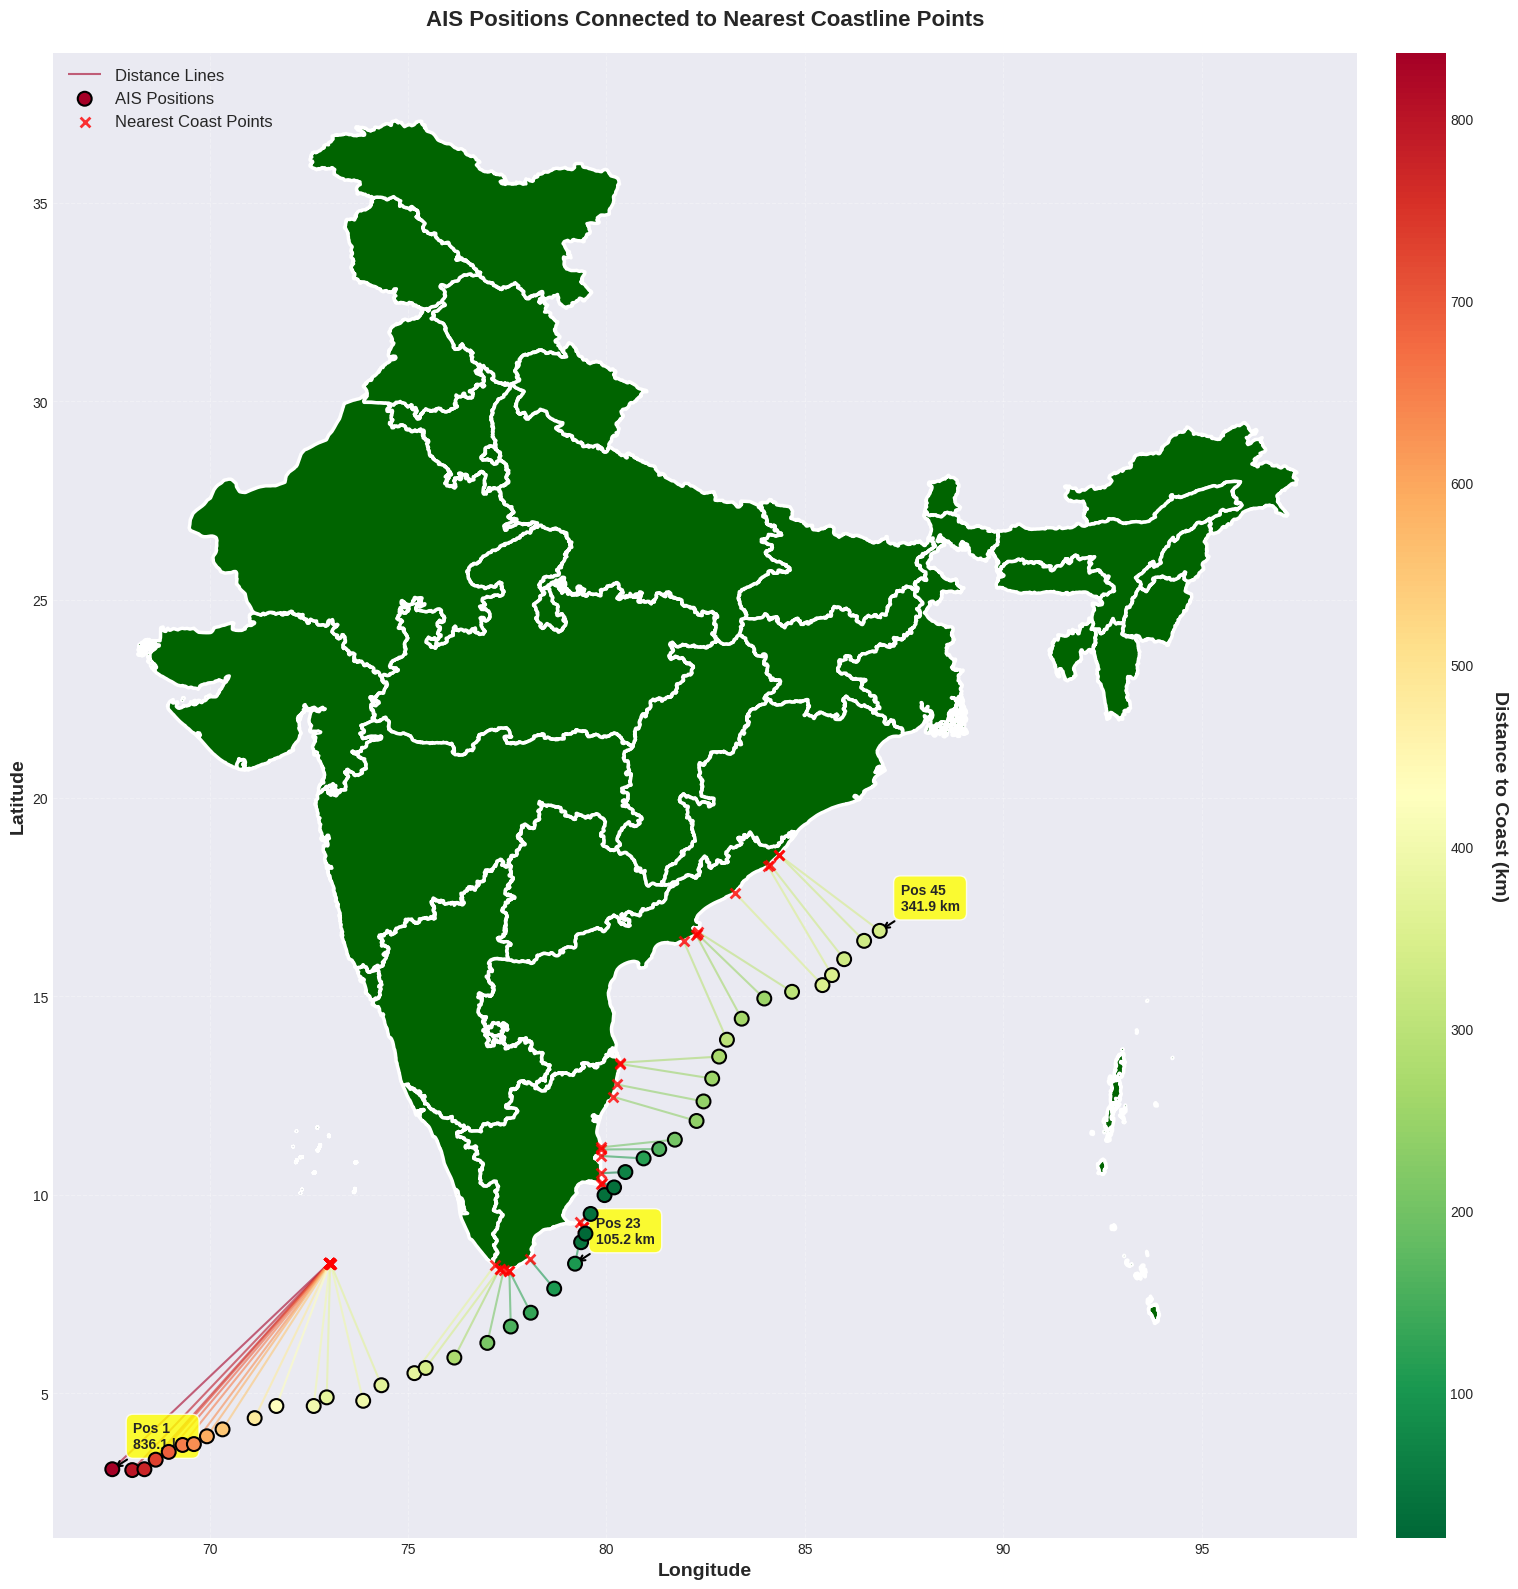


2. Creating detailed regional views...
✓ Saved: coastline_connections_detailed.png


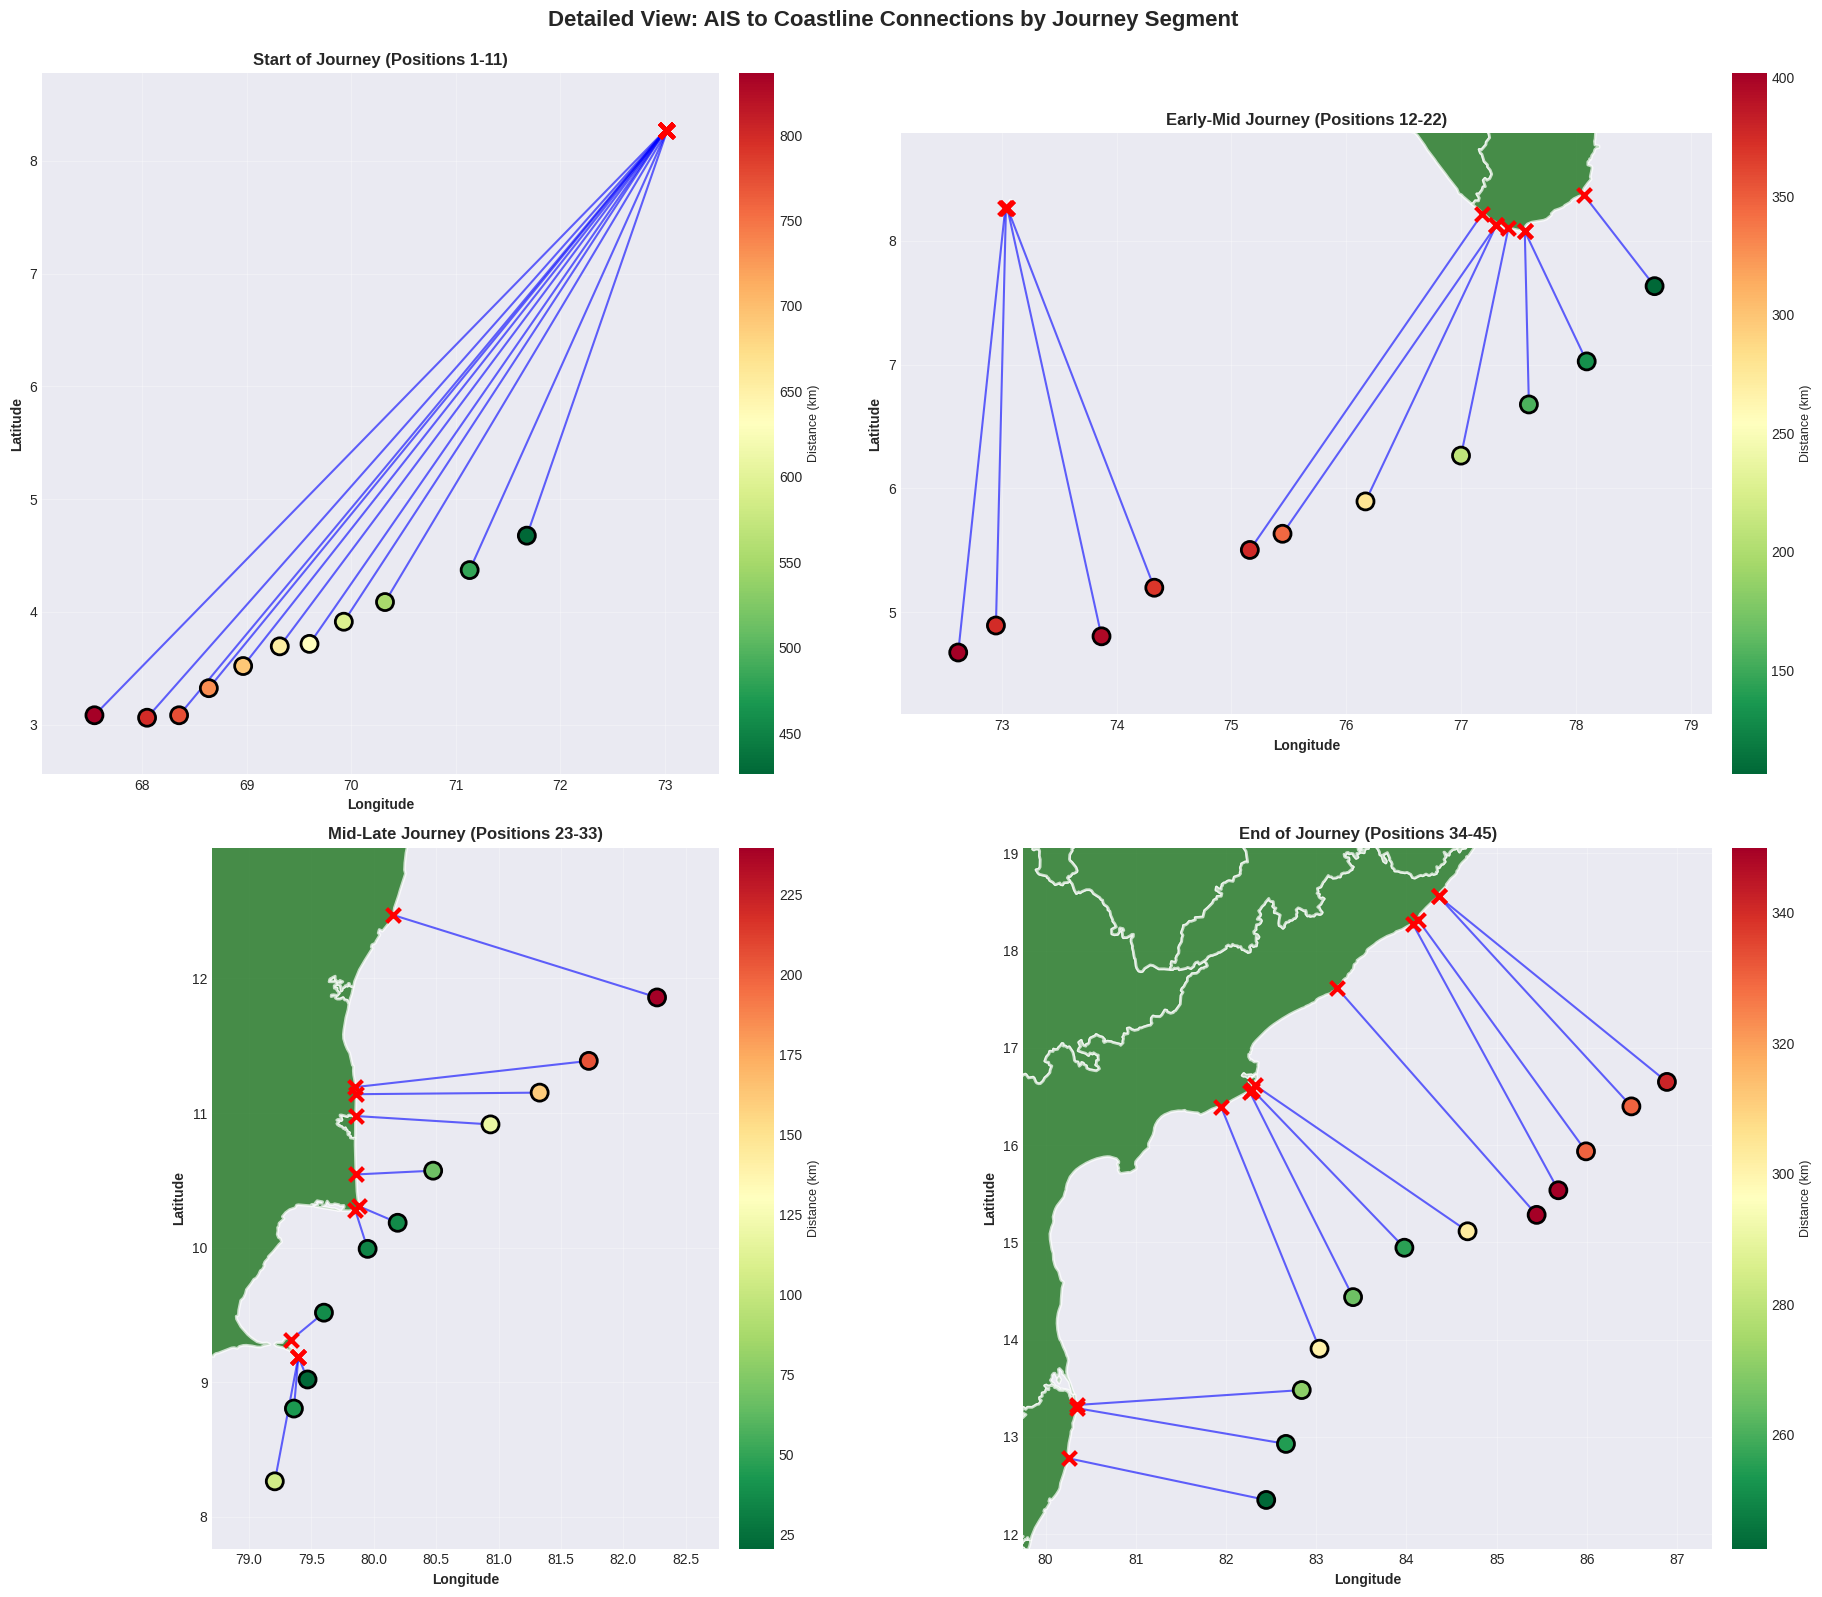


3. Creating interactive Folium map...
✓ Saved: coastline_connections_interactive.html

4. Creating sequential connection visualization...


/tmp/ipykernel_14085/22192291.py:494: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper left', fontsize=12, framealpha=0.9)


✓ Saved: coastline_connections_sequential.png


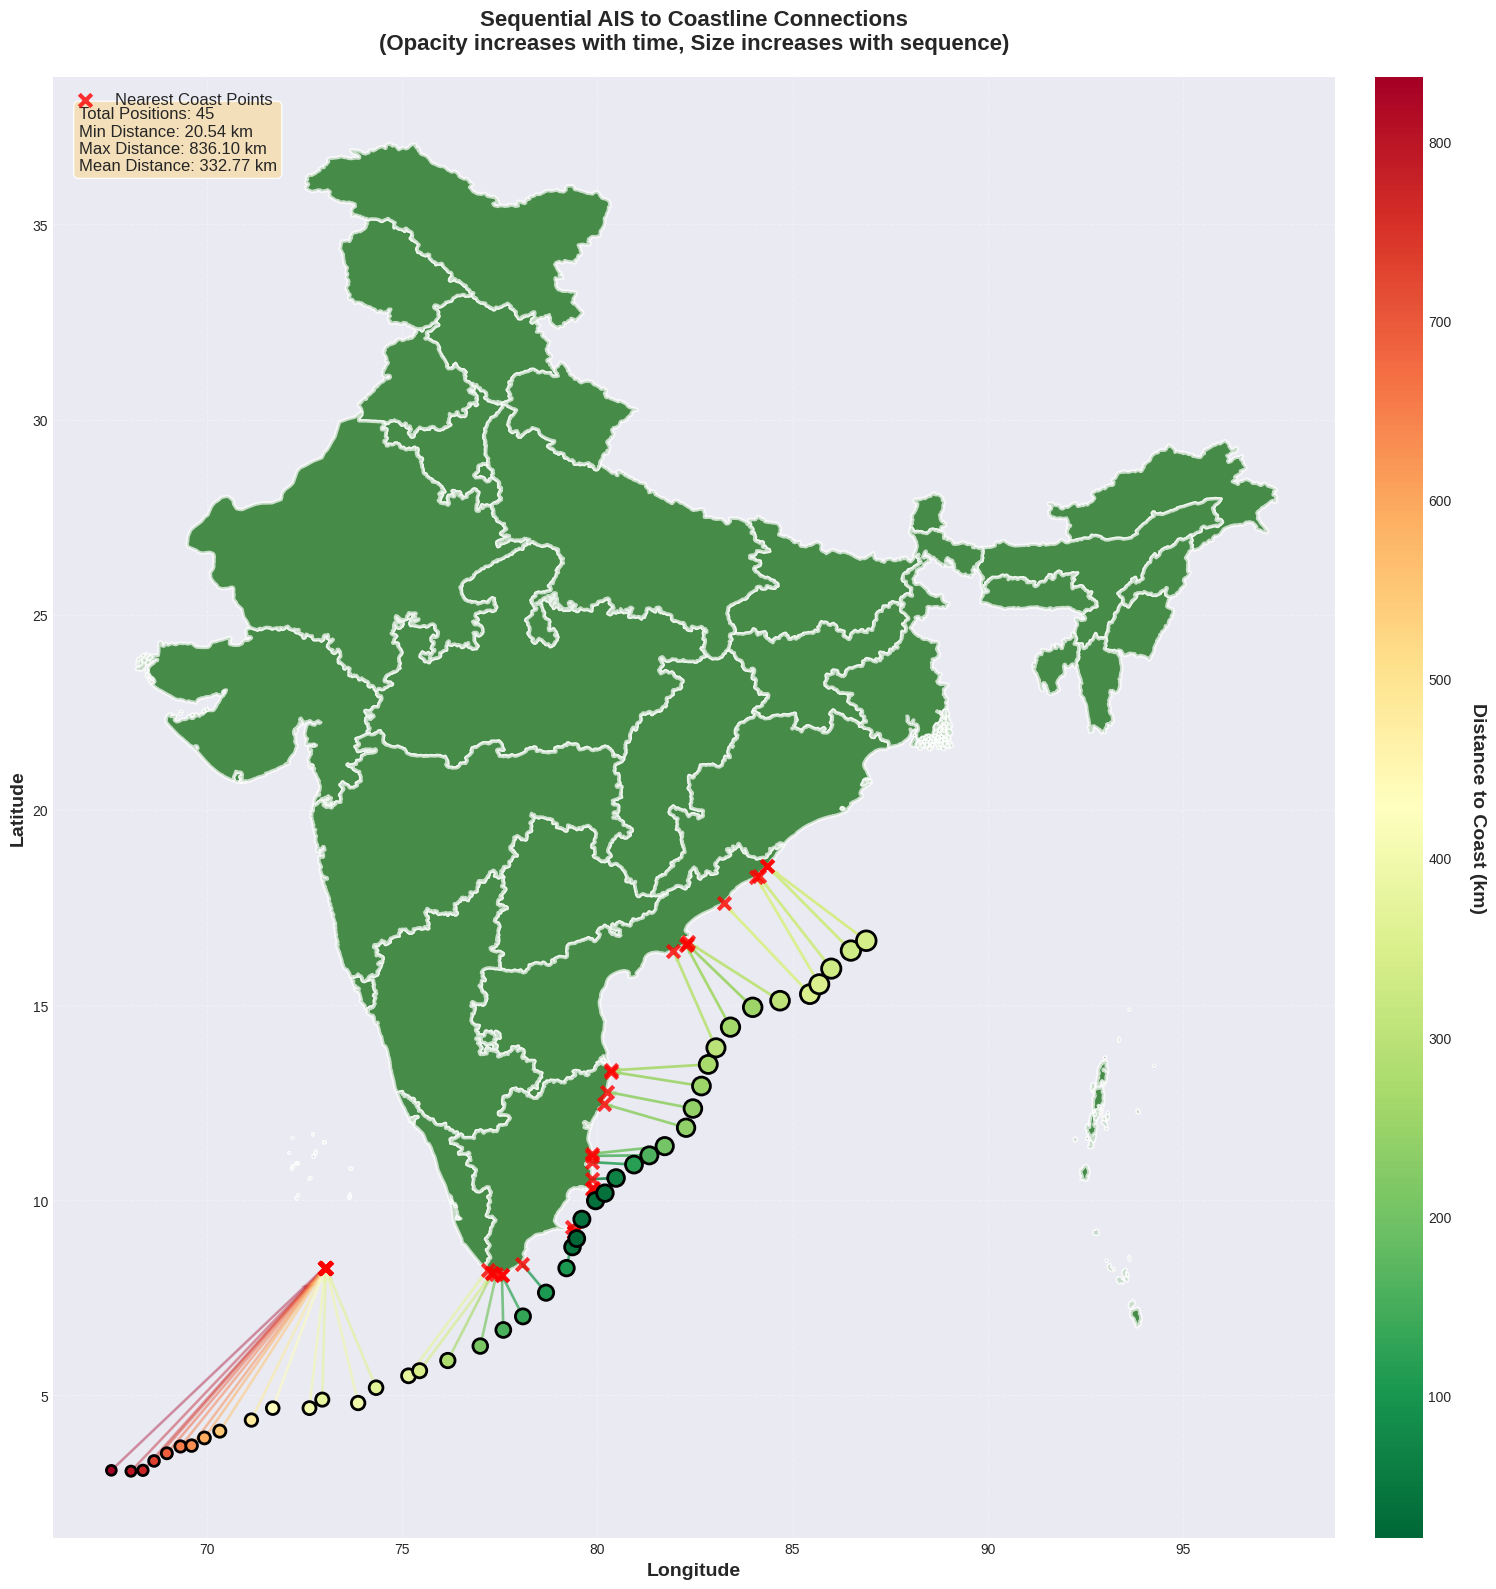


✅ ALL CONNECTION VISUALIZATIONS CREATED SUCCESSFULLY!

Generated Files:
  1. coastline_connections_static.png
     - Full view with all connections shown
  2. coastline_connections_detailed.png
     - 4-panel detailed view by journey segments
  3. coastline_connections_interactive.html
     - Interactive map with clickable connections
  4. coastline_connections_sequential.png
     - Sequential view with fading effect



In [6]:
"""
Visualize AIS Positions Connected to Nearest Coastline Points
Draw lines from each AIS position to the nearest point on the coastline
"""

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from shapely.geometry import Point, LineString
import numpy as np
import folium
from folium import plugins

# ============================================================================
# 1. LOAD DATA
# ============================================================================

print("Loading data...")
coast_dist = pd.read_csv('ais_coast_distances.csv')
coast_dist['timestamp'] = pd.to_datetime(coast_dist['timestamp'])

# Load coastline
coastline_path = '/home/crimsondeepdarshak/Desktop/Deep_Darshak/References/Build_1_docs/Straits_polygon/Coastline/India_coastal_line.json'
coastline_gdf = gpd.read_file(coastline_path)
if coastline_gdf.crs is None:
    coastline_gdf.set_crs('EPSG:4326', inplace=True)

print(f"Loaded {len(coast_dist)} AIS positions")
print(f"Loaded {len(coastline_gdf)} coastline features")

# ============================================================================
# 2. PARSE NEAREST COAST POINTS
# ============================================================================

def parse_coast_points(df):
    """Extract lat/lon from POINT geometry strings"""
    coast_lons = []
    coast_lats = []
    
    for point_str in df['nearest_coast_point']:
        # Parse "POINT (lon lat)" format
        coords_str = point_str.replace('POINT (', '').replace(')', '')
        lon, lat = map(float, coords_str.split())
        coast_lons.append(lon)
        coast_lats.append(lat)
    
    return coast_lats, coast_lons

coast_lats, coast_lons = parse_coast_points(coast_dist)
coast_dist['coast_lat'] = coast_lats
coast_dist['coast_lon'] = coast_lons

print("✓ Parsed nearest coastline points")

# ============================================================================
# 3. MATPLOTLIB STATIC VISUALIZATION
# ============================================================================

def create_static_connection_map():
    """Create static map with connection lines"""
    
    fig, ax = plt.subplots(figsize=(20, 16))
    
    # Plot coastline
    coastline_gdf.plot(ax=ax, color='darkgreen', linewidth=2.5, 
                       label='India Coastline', zorder=2)
    
    # Create connection lines
    lines = []
    colors = []
    
    # Normalize distances for color mapping
    distances = coast_dist['distance_to_coast_km'].values
    min_dist, max_dist = distances.min(), distances.max()
    
    for idx, row in coast_dist.iterrows():
        # Create line from AIS position to nearest coast point
        line = [(row['longitude'], row['latitude']), 
                (row['coast_lon'], row['coast_lat'])]
        lines.append(line)
        
        # Color based on distance (normalized)
        norm_dist = (row['distance_to_coast_km'] - min_dist) / (max_dist - min_dist)
        colors.append(plt.cm.RdYlGn_r(norm_dist))
    
    # Plot connection lines
    line_collection = LineCollection(lines, colors=colors, linewidths=1.5, 
                                     alpha=0.6, zorder=3, label='Distance Lines')
    ax.add_collection(line_collection)
    
    # Plot AIS positions
    ax.scatter(coast_dist['longitude'], coast_dist['latitude'],
               c=distances, cmap='RdYlGn_r', s=100, 
               edgecolors='black', linewidth=1.5, zorder=5,
               label='AIS Positions', vmin=min_dist, vmax=max_dist)
    
    # Plot nearest coast points
    ax.scatter(coast_dist['coast_lon'], coast_dist['coast_lat'],
               c='red', s=50, marker='x', linewidth=2, zorder=4,
               label='Nearest Coast Points', alpha=0.8)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='RdYlGn_r', 
                               norm=plt.Normalize(vmin=min_dist, vmax=max_dist))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02, aspect=30)
    cbar.set_label('Distance to Coast (km)', rotation=270, labelpad=25, 
                   fontsize=14, fontweight='bold')
    
    # Add labels for first, middle, and last positions
    for idx in [0, len(coast_dist)//2, len(coast_dist)-1]:
        row = coast_dist.iloc[idx]
        
        # Label AIS position
        ax.annotate(f'Pos {idx+1}\n{row["distance_to_coast_km"]:.1f} km',
                   xy=(row['longitude'], row['latitude']),
                   xytext=(15, 15), textcoords='offset points',
                   bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.8),
                   arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
                   fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Longitude', fontsize=14, fontweight='bold')
    ax.set_ylabel('Latitude', fontsize=14, fontweight='bold')
    ax.set_title('AIS Positions Connected to Nearest Coastline Points', 
                 fontsize=16, fontweight='bold', pad=20)
    
    ax.legend(loc='upper left', fontsize=12, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.savefig('coastline_connections_static.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: coastline_connections_static.png")
    plt.show()

# ============================================================================
# 4. MATPLOTLIB ZOOMED VIEW (DETAILED)
# ============================================================================

def create_detailed_connection_view():
    """Create detailed view showing individual connections clearly"""
    
    # Create subplots for different regions
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.flatten()
    
    # Define 4 regions to zoom into
    n_positions = len(coast_dist)
    regions = [
        (0, n_positions//4, "Start of Journey"),
        (n_positions//4, n_positions//2, "Early-Mid Journey"),
        (n_positions//2, 3*n_positions//4, "Mid-Late Journey"),
        (3*n_positions//4, n_positions, "End of Journey")
    ]
    
    for idx, (start, end, title) in enumerate(regions):
        ax = axes[idx]
        
        # Get subset of data
        subset = coast_dist.iloc[start:end]
        
        # Plot coastline
        coastline_gdf.plot(ax=ax, color='darkgreen', linewidth=2, 
                          alpha=0.7, zorder=1)
        
        # Plot connection lines
        for _, row in subset.iterrows():
            ax.plot([row['longitude'], row['coast_lon']], 
                   [row['latitude'], row['coast_lat']],
                   color='blue', linewidth=1.5, alpha=0.6, zorder=2)
        
        # Plot AIS positions
        distances = subset['distance_to_coast_km'].values
        scatter = ax.scatter(subset['longitude'], subset['latitude'],
                            c=distances, cmap='RdYlGn_r', s=150, 
                            edgecolors='black', linewidth=2, zorder=4)
        
        # Plot nearest coast points
        ax.scatter(subset['coast_lon'], subset['coast_lat'],
                  c='red', s=100, marker='x', linewidth=3, zorder=3)
        
        # Add position numbers
        for pos_idx, row in subset.iterrows():
            ax.annotate(f'{pos_idx+1}',
                       xy=(row['longitude'], row['latitude']),
                       xytext=(0, 0), textcoords='offset points',
                       ha='center', va='center',
                       fontsize=8, fontweight='bold', color='white')
        
        # Calculate bounds with padding
        lon_min = min(subset['longitude'].min(), subset['coast_lon'].min())
        lon_max = max(subset['longitude'].max(), subset['coast_lon'].max())
        lat_min = min(subset['latitude'].min(), subset['coast_lat'].min())
        lat_max = max(subset['latitude'].max(), subset['coast_lat'].max())
        
        padding = 0.5
        ax.set_xlim(lon_min - padding, lon_max + padding)
        ax.set_ylim(lat_min - padding, lat_max + padding)
        
        ax.set_title(f'{title} (Positions {start+1}-{end})', 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('Longitude', fontsize=10, fontweight='bold')
        ax.set_ylabel('Latitude', fontsize=10, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Add colorbar for each subplot
        cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02)
        cbar.set_label('Distance (km)', fontsize=9)
    
    plt.suptitle('Detailed View: AIS to Coastline Connections by Journey Segment', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('coastline_connections_detailed.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: coastline_connections_detailed.png")
    plt.show()

# ============================================================================
# 5. INTERACTIVE FOLIUM MAP WITH CONNECTIONS
# ============================================================================

def create_interactive_connection_map():
    """Create interactive Folium map with connection lines"""
    
    # Calculate center
    center_lat = coast_dist['latitude'].mean()
    center_lon = coast_dist['longitude'].mean()
    
    # Create map
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=5,
        tiles='OpenStreetMap'
    )
    
    # Add alternative tiles
    folium.TileLayer('CartoDB positron', name='Light Map').add_to(m)
    folium.TileLayer('CartoDB dark_matter', name='Dark Map').add_to(m)
    
    # Add coastline
    coastline_layer = folium.FeatureGroup(name='Coastline', show=True)
    folium.GeoJson(
        coastline_gdf,
        style_function=lambda x: {
            'color': '#059669',
            'weight': 3,
            'fillOpacity': 0
        }
    ).add_to(coastline_layer)
    coastline_layer.add_to(m)
    
    # Add connection lines layer
    connections_layer = folium.FeatureGroup(name='Distance Connections', show=True)
    
    # Normalize distances for colors
    distances = coast_dist['distance_to_coast_km'].values
    min_dist, max_dist = distances.min(), distances.max()
    
    for idx, row in coast_dist.iterrows():
        # Calculate color based on distance
        norm_dist = (row['distance_to_coast_km'] - min_dist) / (max_dist - min_dist)
        
        if norm_dist < 0.33:
            color = '#22c55e'  # Green - close
        elif norm_dist < 0.66:
            color = '#f59e0b'  # Orange - medium
        else:
            color = '#ef4444'  # Red - far
        
        # Draw line from AIS position to nearest coast point
        folium.PolyLine(
            locations=[
                [row['latitude'], row['longitude']],
                [row['coast_lat'], row['coast_lon']]
            ],
            color=color,
            weight=2,
            opacity=0.7,
            popup=f"""
                <b>Position {idx+1}</b><br>
                Distance: {row['distance_to_coast_km']:.2f} km<br>
                Time: {row['timestamp']}
            """
        ).add_to(connections_layer)
    
    connections_layer.add_to(m)
    
    # Add AIS positions layer
    ais_layer = folium.FeatureGroup(name='AIS Positions', show=True)
    
    for idx, row in coast_dist.iterrows():
        dist = row['distance_to_coast_km']
        
        # Marker color based on distance
        if dist < 50:
            marker_color = 'green'
        elif dist < 150:
            marker_color = 'orange'
        else:
            marker_color = 'red'
        
        popup_html = f"""
        <div style="font-family: Arial; width: 280px;">
            <h4 style="margin: 0; color: #1f2937;">AIS Position #{idx + 1}</h4>
            <hr style="margin: 5px 0;">
            <b>Timestamp:</b> {row['timestamp']}<br>
            <b>AIS Location:</b><br>
            &nbsp;&nbsp;Lat: {row['latitude']:.4f}°<br>
            &nbsp;&nbsp;Lon: {row['longitude']:.4f}°<br>
            <b>Nearest Coast Point:</b><br>
            &nbsp;&nbsp;Lat: {row['coast_lat']:.4f}°<br>
            &nbsp;&nbsp;Lon: {row['coast_lon']:.4f}°<br>
            <b>Distance:</b> {row['distance_to_coast_km']:.2f} km
        </div>
        """
        
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=folium.Popup(popup_html, max_width=300),
            tooltip=f"Pos {idx + 1}: {row['distance_to_coast_km']:.1f} km",
            icon=folium.Icon(color=marker_color, icon='ship', prefix='fa')
        ).add_to(ais_layer)
    
    ais_layer.add_to(m)
    
    # Add nearest coast points layer
    coast_points_layer = folium.FeatureGroup(name='Nearest Coast Points', show=True)
    
    for idx, row in coast_dist.iterrows():
        folium.CircleMarker(
            location=[row['coast_lat'], row['coast_lon']],
            radius=4,
            color='red',
            fill=True,
            fillColor='red',
            fillOpacity=0.8,
            popup=f"Nearest point for Position {idx + 1}",
            tooltip=f"Coast point for Pos {idx + 1}"
        ).add_to(coast_points_layer)
    
    coast_points_layer.add_to(m)
    
    # Add route line
    route_layer = folium.FeatureGroup(name='AIS Track', show=True)
    route_coords = [[row['latitude'], row['longitude']] 
                    for _, row in coast_dist.iterrows()]
    folium.PolyLine(
        route_coords,
        color='blue',
        weight=2,
        opacity=0.6,
        dash_array='5, 10'
    ).add_to(route_layer)
    route_layer.add_to(m)
    
    # Add legend
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; right: 50px; width: 300px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:12px; padding: 15px; border-radius: 5px;
                box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
        <h4 style="margin-top:0; color: #1f2937;">Connection Lines Legend</h4>
        <p style="margin: 5px 0;">
            <span style="color: #22c55e; font-size: 18px;">━━</span> 
            <b>Close</b> (&lt;33% of max distance)
        </p>
        <p style="margin: 5px 0;">
            <span style="color: #f59e0b; font-size: 18px;">━━</span> 
            <b>Medium</b> (33-66% of max distance)
        </p>
        <p style="margin: 5px 0;">
            <span style="color: #ef4444; font-size: 18px;">━━</span> 
            <b>Far</b> (&gt;66% of max distance)
        </p>
        <hr style="margin: 10px 0;">
        <p style="margin: 5px 0; font-size: 11px;">
            <span style="color: #3b82f6;">⚓</span> AIS Position<br>
            <span style="color: #ef4444;">✕</span> Nearest Coast Point<br>
            Lines connect each position to coast
        </p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Add title
    title_html = '''
    <div style="position: fixed; 
                top: 10px; left: 50px; width: 550px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:16px; font-weight: bold; padding: 10px;
                border-radius: 5px; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
        <span style="color: #1f2937;">🚢 AIS Positions Connected to Coastline</span>
        <br>
        <span style="font-size: 12px; font-weight: normal; color: #6b7280;">
            Each vessel position connected to its nearest point on the coast
        </span>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(title_html))
    
    # Add measurement tool
    m.add_child(folium.plugins.MeasureControl())
    
    # Add fullscreen
    plugins.Fullscreen().add_to(m)
    
    # Add layer control
    folium.LayerControl(collapsed=False).add_to(m)
    
    return m

# ============================================================================
# 6. ANIMATED VIEW (SEQUENTIAL CONNECTIONS)
# ============================================================================

def create_sequential_connection_plot():
    """Create plot showing connections appearing sequentially"""
    
    fig, ax = plt.subplots(figsize=(20, 16))
    
    # Plot coastline
    coastline_gdf.plot(ax=ax, color='darkgreen', linewidth=2.5, 
                       label='India Coastline', zorder=1, alpha=0.7)
    
    # Normalize distances for colors
    distances = coast_dist['distance_to_coast_km'].values
    min_dist, max_dist = distances.min(), distances.max()
    
    # Plot all connection lines with varying alpha (fading effect)
    for idx, row in coast_dist.iterrows():
        # Alpha decreases for older positions
        alpha = 0.3 + 0.7 * (idx / len(coast_dist))
        
        # Color based on distance
        norm_dist = (row['distance_to_coast_km'] - min_dist) / (max_dist - min_dist)
        color = plt.cm.RdYlGn_r(norm_dist)
        
        # Draw connection line
        ax.plot([row['longitude'], row['coast_lon']], 
               [row['latitude'], row['coast_lat']],
               color=color, linewidth=2, alpha=alpha, zorder=2)
        
        # Draw arrow to show direction
        dx = row['coast_lon'] - row['longitude']
        dy = row['coast_lat'] - row['latitude']
        ax.arrow(row['longitude'], row['latitude'], dx*0.9, dy*0.9,
                head_width=0.1, head_length=0.1, fc=color, ec=color,
                alpha=alpha*0.5, zorder=2)
    
    # Plot AIS positions with size based on sequence
    sizes = np.linspace(50, 200, len(coast_dist))
    scatter = ax.scatter(coast_dist['longitude'], coast_dist['latitude'],
                        c=distances, cmap='RdYlGn_r', s=sizes, 
                        edgecolors='black', linewidth=2, zorder=4,
                        vmin=min_dist, vmax=max_dist)
    
    # Plot nearest coast points
    ax.scatter(coast_dist['coast_lon'], coast_dist['coast_lat'],
              c='red', s=80, marker='x', linewidth=3, zorder=3,
              label='Nearest Coast Points', alpha=0.8)
    
    # Add position numbers for every 5th position
    for idx in range(0, len(coast_dist), 5):
        row = coast_dist.iloc[idx]
        ax.annotate(f'{idx+1}',
                   xy=(row['longitude'], row['latitude']),
                   fontsize=10, fontweight='bold', 
                   ha='center', va='center', color='white')
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02, aspect=30)
    cbar.set_label('Distance to Coast (km)', rotation=270, labelpad=25, 
                   fontsize=14, fontweight='bold')
    
    # Add statistics box
    stats_text = f'Total Positions: {len(coast_dist)}\n'
    stats_text += f'Min Distance: {min_dist:.2f} km\n'
    stats_text += f'Max Distance: {max_dist:.2f} km\n'
    stats_text += f'Mean Distance: {distances.mean():.2f} km'
    
    ax.text(0.02, 0.98, stats_text,
            transform=ax.transAxes,
            fontsize=12,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))
    
    ax.set_xlabel('Longitude', fontsize=14, fontweight='bold')
    ax.set_ylabel('Latitude', fontsize=14, fontweight='bold')
    ax.set_title('Sequential AIS to Coastline Connections\n(Opacity increases with time, Size increases with sequence)', 
                 fontsize=16, fontweight='bold', pad=20)
    
    ax.legend(loc='upper left', fontsize=12, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.savefig('coastline_connections_sequential.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: coastline_connections_sequential.png")
    plt.show()

# ============================================================================
# 7. MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("\n" + "="*70)
    print("AIS TO COASTLINE CONNECTION VISUALIZATION")
    print("="*70)
    
    print("\n1. Creating static connection map...")
    create_static_connection_map()
    
    print("\n2. Creating detailed regional views...")
    create_detailed_connection_view()
    
    print("\n3. Creating interactive Folium map...")
    interactive_map = create_interactive_connection_map()
    interactive_map.save('coastline_connections_interactive.html')
    print("✓ Saved: coastline_connections_interactive.html")
    
    print("\n4. Creating sequential connection visualization...")
    create_sequential_connection_plot()
    
    print("\n" + "="*70)
    print("✅ ALL CONNECTION VISUALIZATIONS CREATED SUCCESSFULLY!")
    print("="*70)
    print("\nGenerated Files:")
    print("  1. coastline_connections_static.png")
    print("     - Full view with all connections shown")
    print("  2. coastline_connections_detailed.png")
    print("     - 4-panel detailed view by journey segments")
    print("  3. coastline_connections_interactive.html")
    print("     - Interactive map with clickable connections")
    print("  4. coastline_connections_sequential.png")
    print("     - Sequential view with fading effect")
    print("\n" + "="*70)